In [124]:
import numpy as np
import pandas as pd
import datetime
import urllib
import json
from sklearn.decomposition import PCA
import shapefile as shp
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


C:\Users\Nurvirta\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['std', 'Polygon']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Load Data

In [3]:
nyc_coll = pd.read_csv('NYC_collision_2.csv')

In [4]:
nyc_coll['date'] = pd.to_datetime(nyc_coll['date'])
nyc_coll['yearmonth'] = nyc_coll['date'].map(lambda x: 100*x.year + x.month)
nyc_coll.head()

Unnamed: 0       date   time  hour  dayofweek  year  pedestrian_injured  \
0           0 2015-04-04   9:25     9          5  2015                   0   
1           1 2015-04-04  21:15    21          5  2015                   0   
2           2 2015-04-04  16:52    16          5  2015                   0   
3           3 2015-04-04   9:30     9          5  2015                   0   
4           4 2015-04-04   9:41     9          5  2015                   0   

   cyclist_injured  motorist_injured  pedestrian_killed  cyclist_killed  \
0                0                 0                  0               0   
1                0                 1                  0               0   
2                0                 0                  0               0   
3                0                 0                  0               0   
4                0                 0                  0               0   

   motorist_killed            vehicle        lat       long  \
0                0      PICK-UP TRUCK  40.750788 -74.005630   
1                0  PASSENGER VEHICLE  40.781291 -73.814200   
2                0  PASSENGER VEHICLE  40.702595 -73.855293   
3                0  PASSENGER VEHICLE  40.804886 -73.962474   
4                0  PASSENGER VEHICLE  40.715144 -73.749356   

             contributing_factor  yearmonth  
0        Prescription Medication     201504  
1  Failure to Yield Right-of-Way     201504  
2             Turning Improperly     201504  
3                    Unspecified     201504  
4        Outside Car Distraction     201504

# Function to Visualize Data by YEAR

In [5]:
def plotYearly(df, title,alpha):
    fig = plt.figure(figsize=(30,10))
    plt.suptitle(title, fontsize=30)
    for i in range(3):
        ax = fig.add_subplot(1,3,i+1)
        df_year = df[df['year']==2012+i]
        pts = np.array(df_year.loc[:,['long','lat']].astype(float))
        ax.scatter(pts[:,0],pts[:,1], lw=0, color='k',alpha=alpha)
        ax.set_title(str(2012+i), fontsize=20)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.axis('off')
    plt.tight_layout(w_pad=0.2, h_pad=0.2, pad=6)

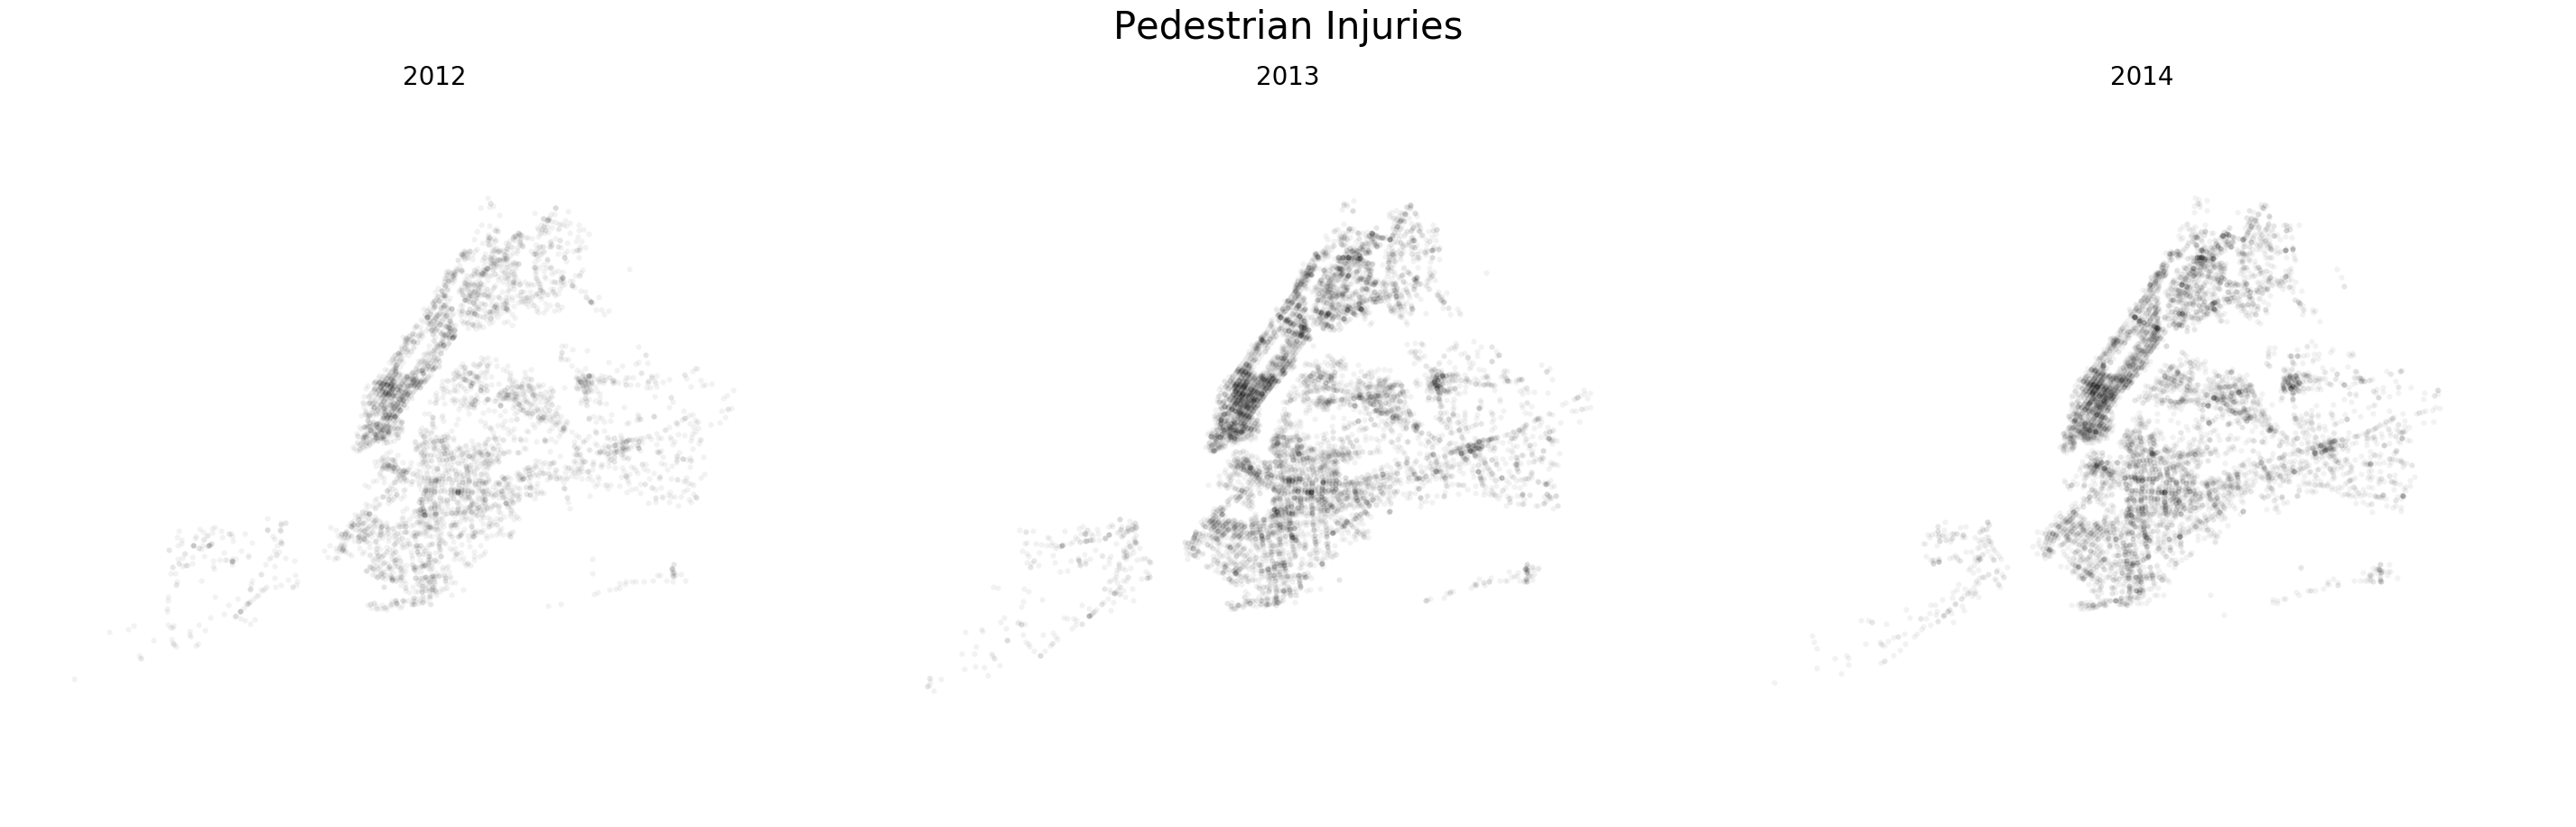

In [6]:
# SUBSET DATA FIRST
nyc_coll_original = nyc_coll.copy()
nyc_coll = nyc_coll[(nyc_coll.year>=2012)&(nyc_coll.year<=2014)]
ped = nyc_coll[(nyc_coll.pedestrian_injured > 0)]
ped_died = nyc_coll[nyc_coll.pedestrian_killed > 0]

# VISUALIZE
plotYearly(ped, 'Pedestrian Injuries',0.05)

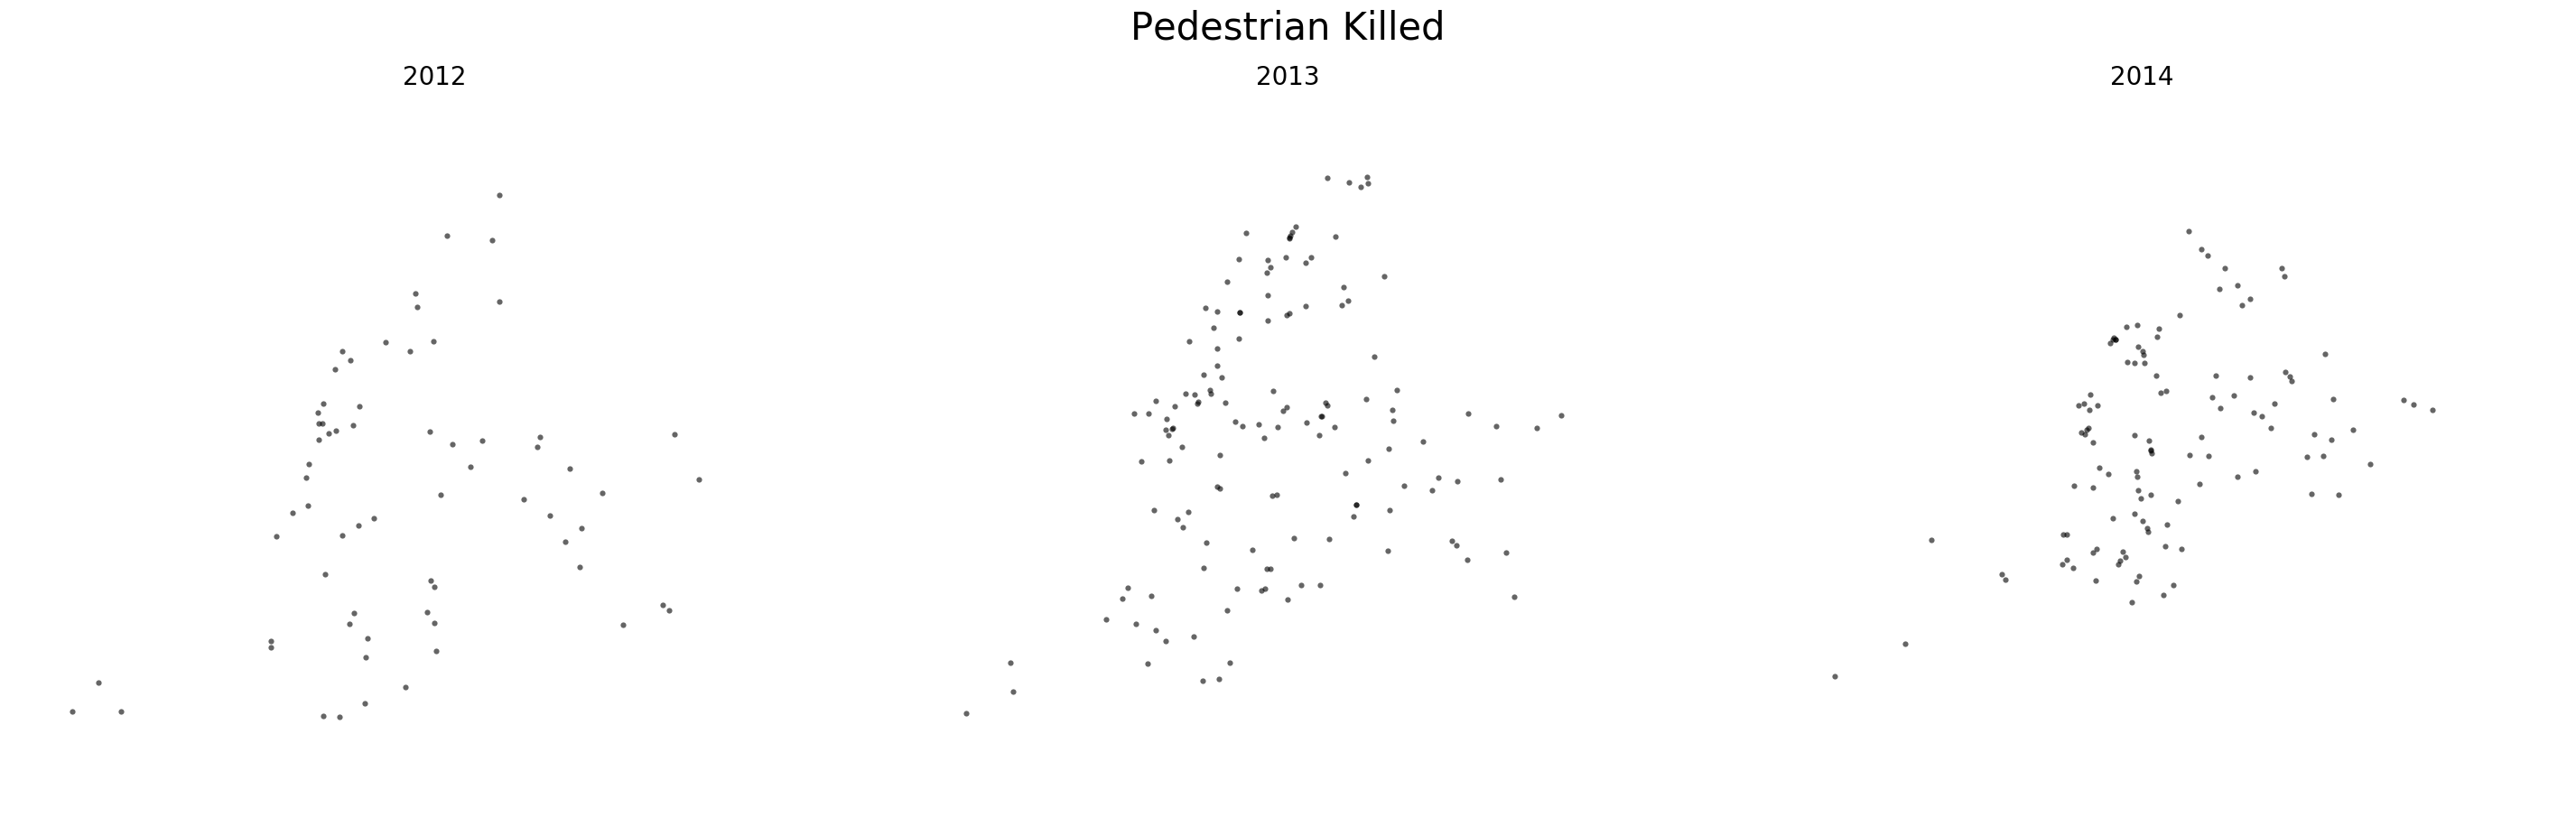

In [7]:
plotYearly(ped_died, 'Pedestrian Killed',0.6)

In [8]:
cyc = nyc_coll[nyc_coll.cyclist_injured > 0]

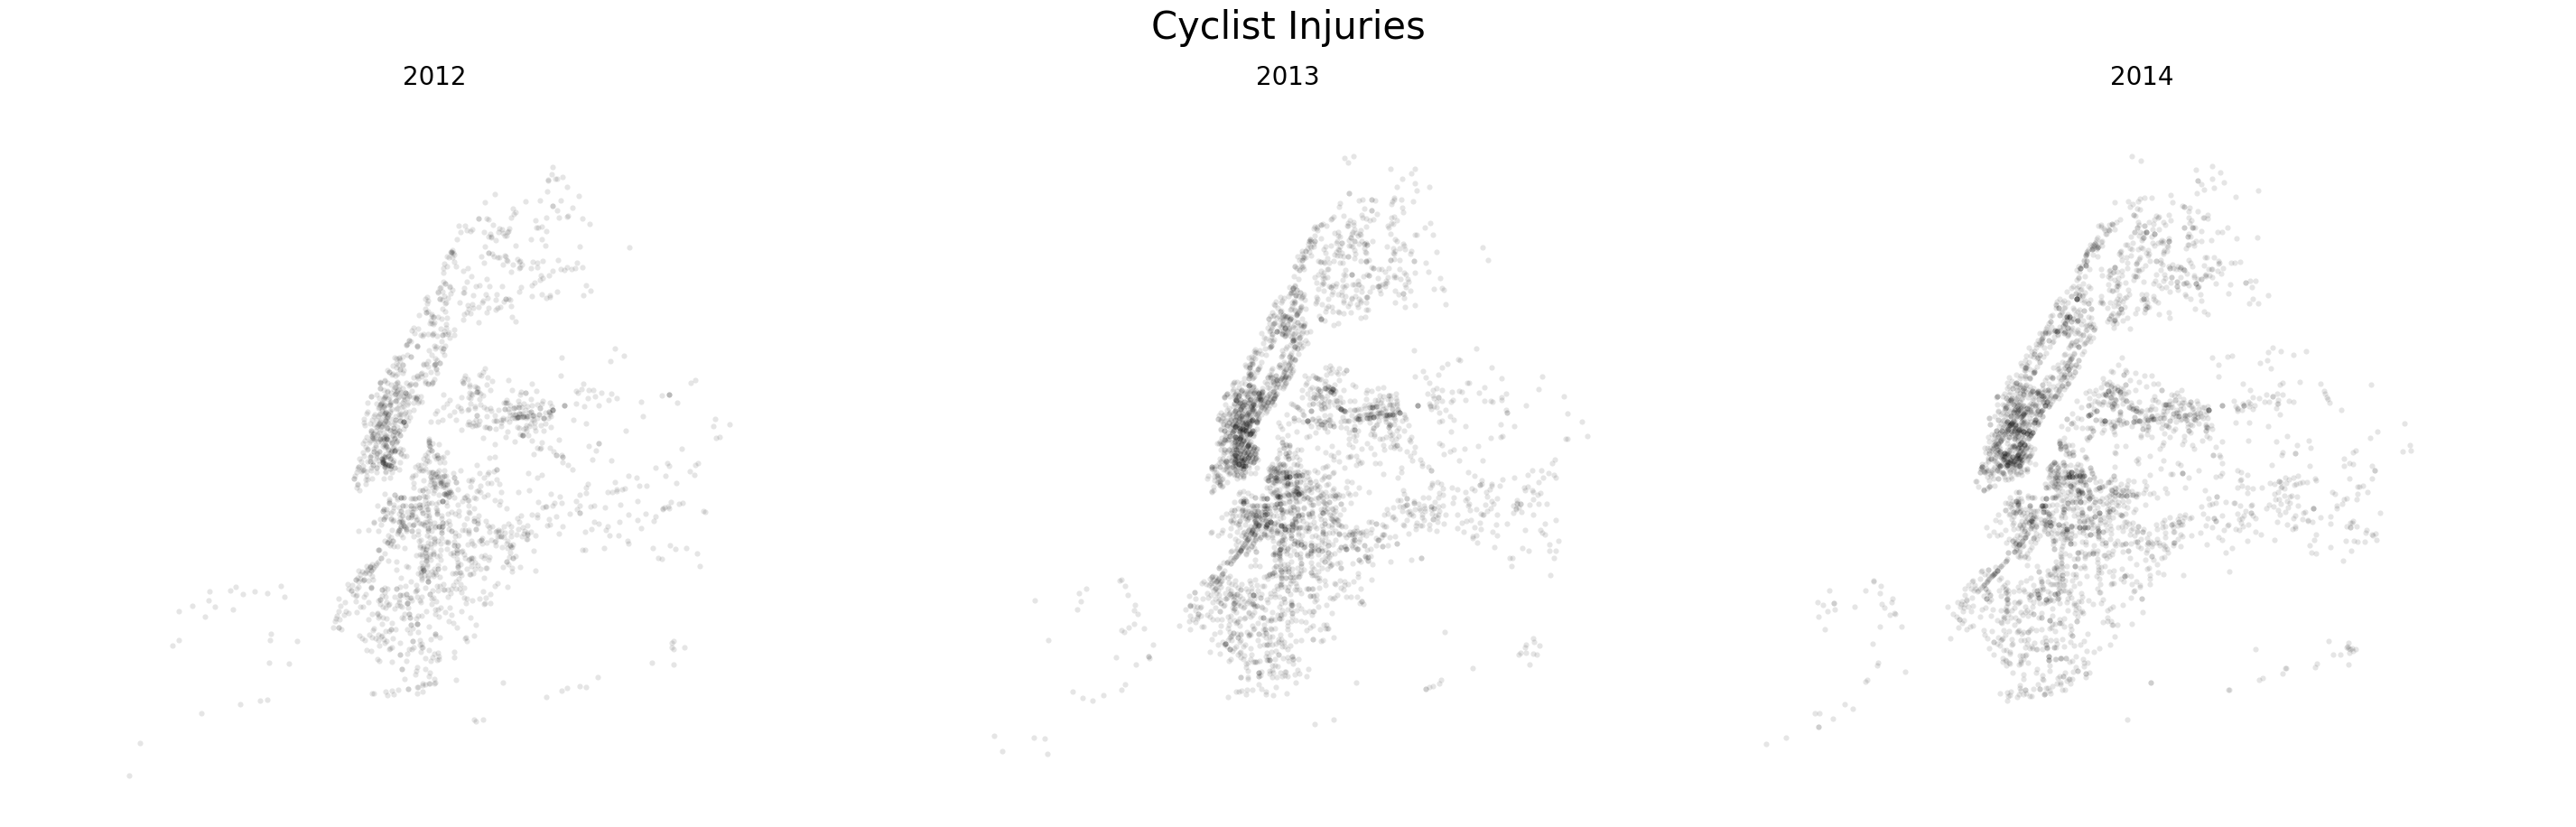

In [9]:
plotYearly(cyc, 'Cyclist Injuries', 0.1)

In [10]:
mot = nyc_coll[nyc_coll.motorist_injured > 0]

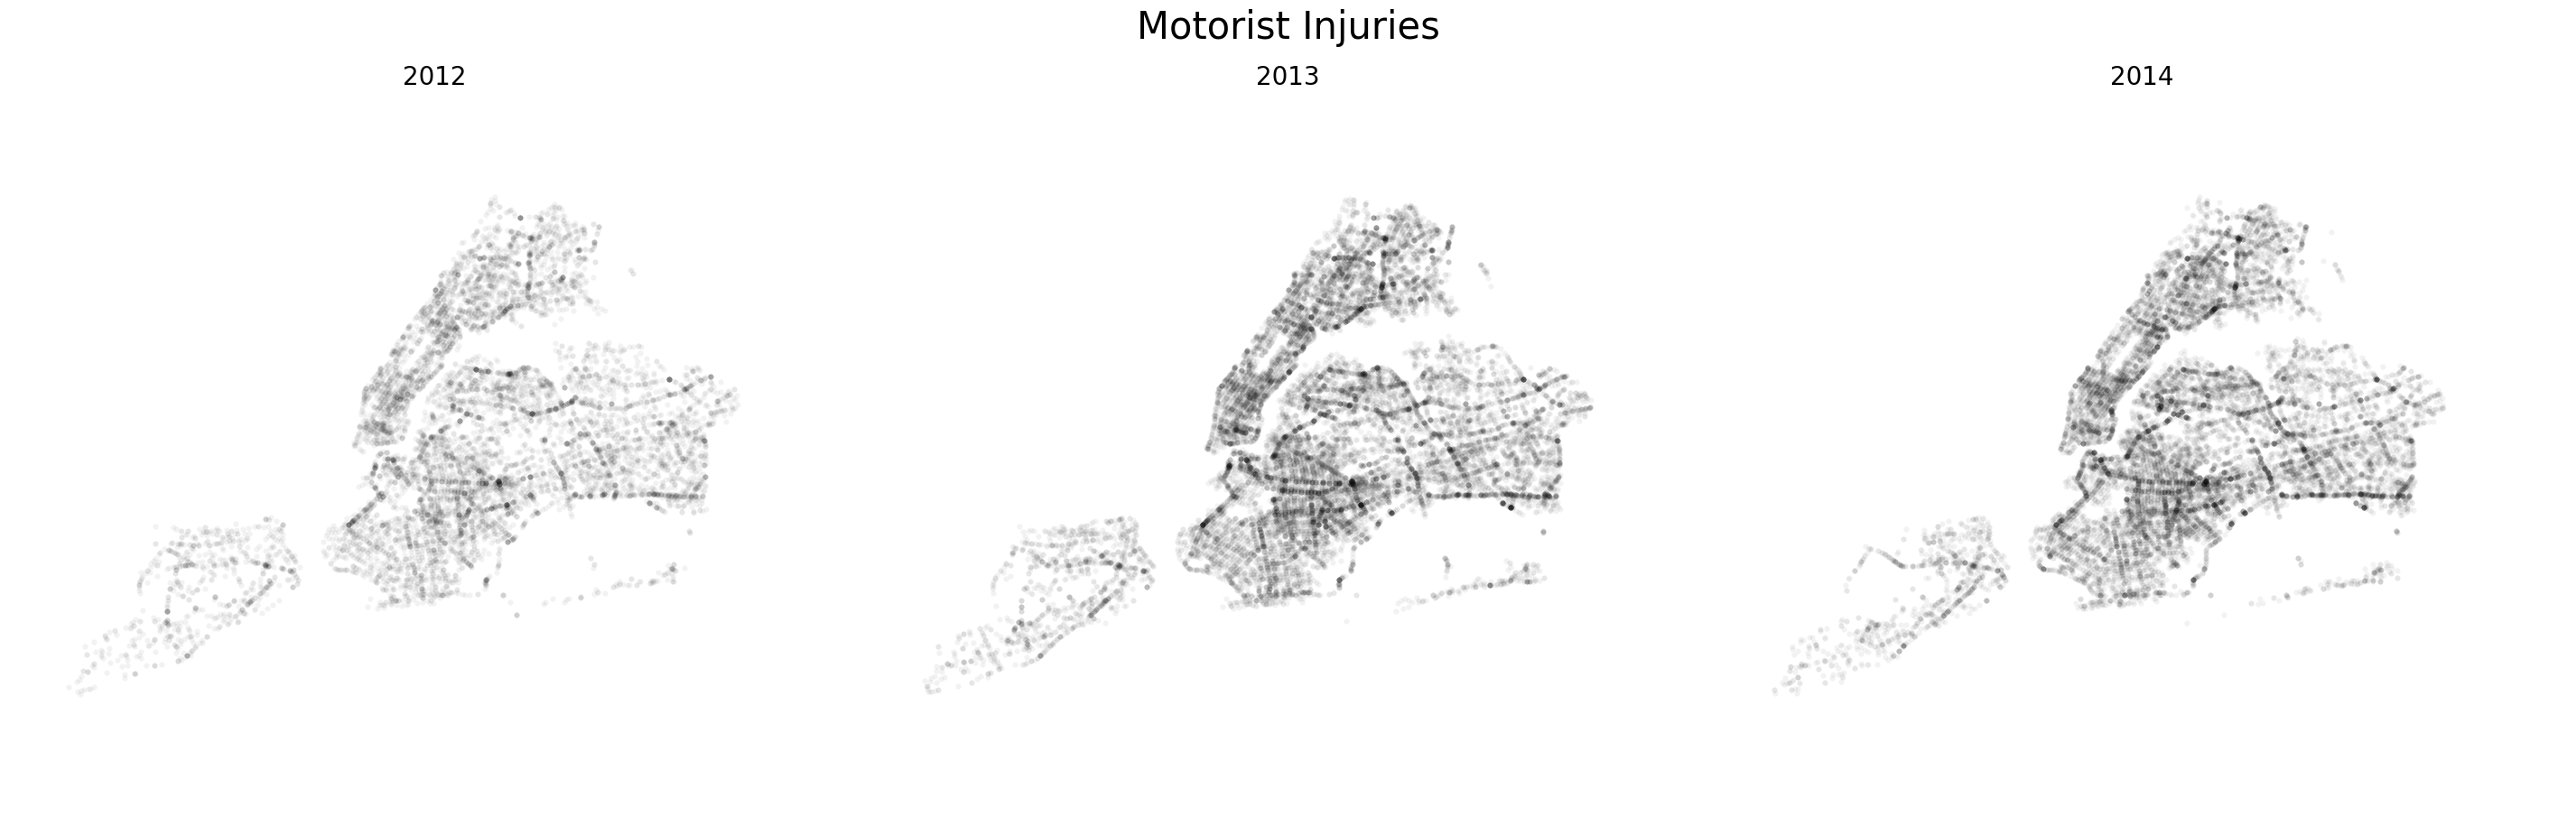

In [11]:
plotYearly(mot, 'Motorist Injuries', 0.05)

In [12]:
bus = nyc_coll[nyc_coll.vehicle == 'BUS']

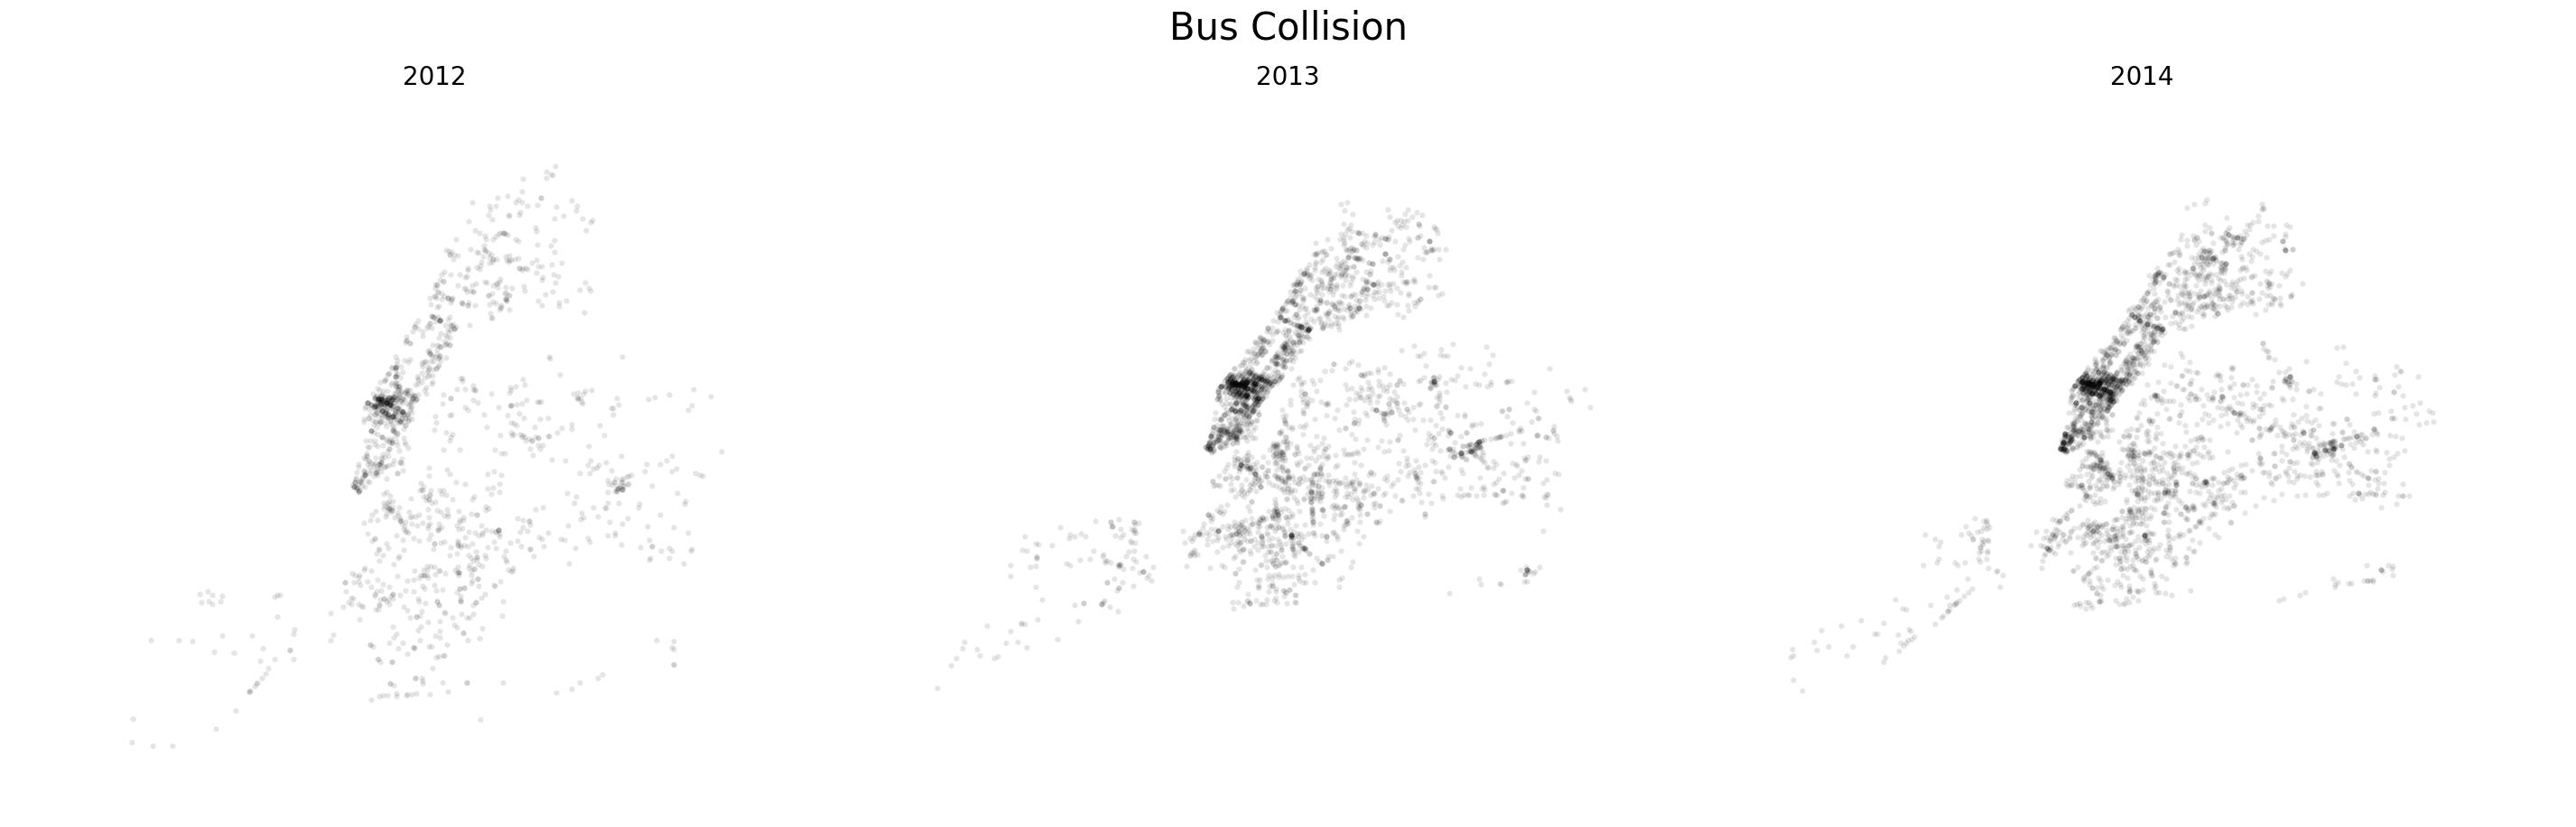

In [13]:
plotYearly(bus, 'Bus Collision', 0.1)

In [14]:
print 'Bus collision contributing factor:'
print bus.groupby('contributing_factor').count().iloc[:,0].sort_values(ascending=False).head()

Bus collision contributing factor:
contributing_factor
Unspecified                       4532
Driver Inattention/Distraction     932
Lost Consciousness                 314
Fatigued/Drowsy                    308
Other Vehicular                    302
Name: Unnamed: 0, dtype: int64


In [15]:
taxi = nyc_coll[nyc_coll.vehicle == 'TAXI']

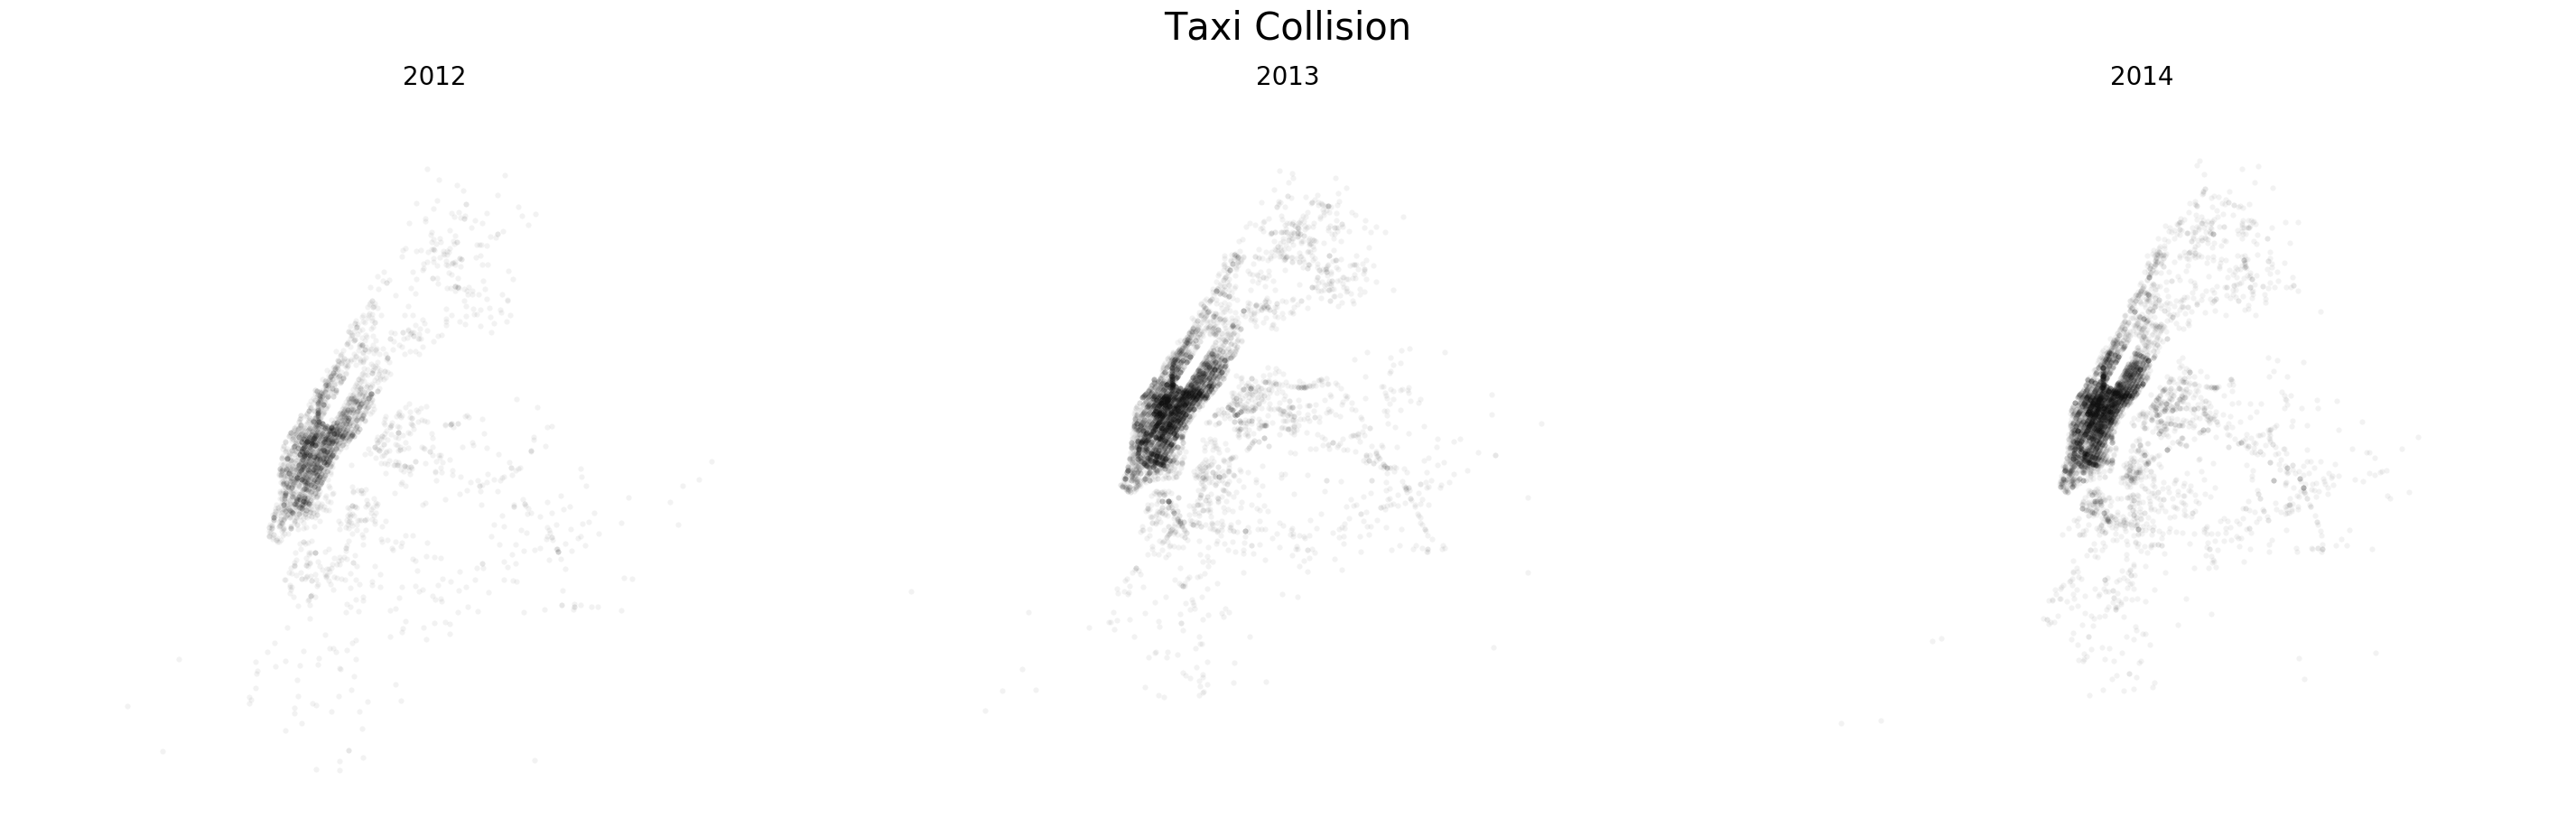

In [16]:
plotYearly(taxi, 'Taxi Collision', 0.05)

# Visualize data by category

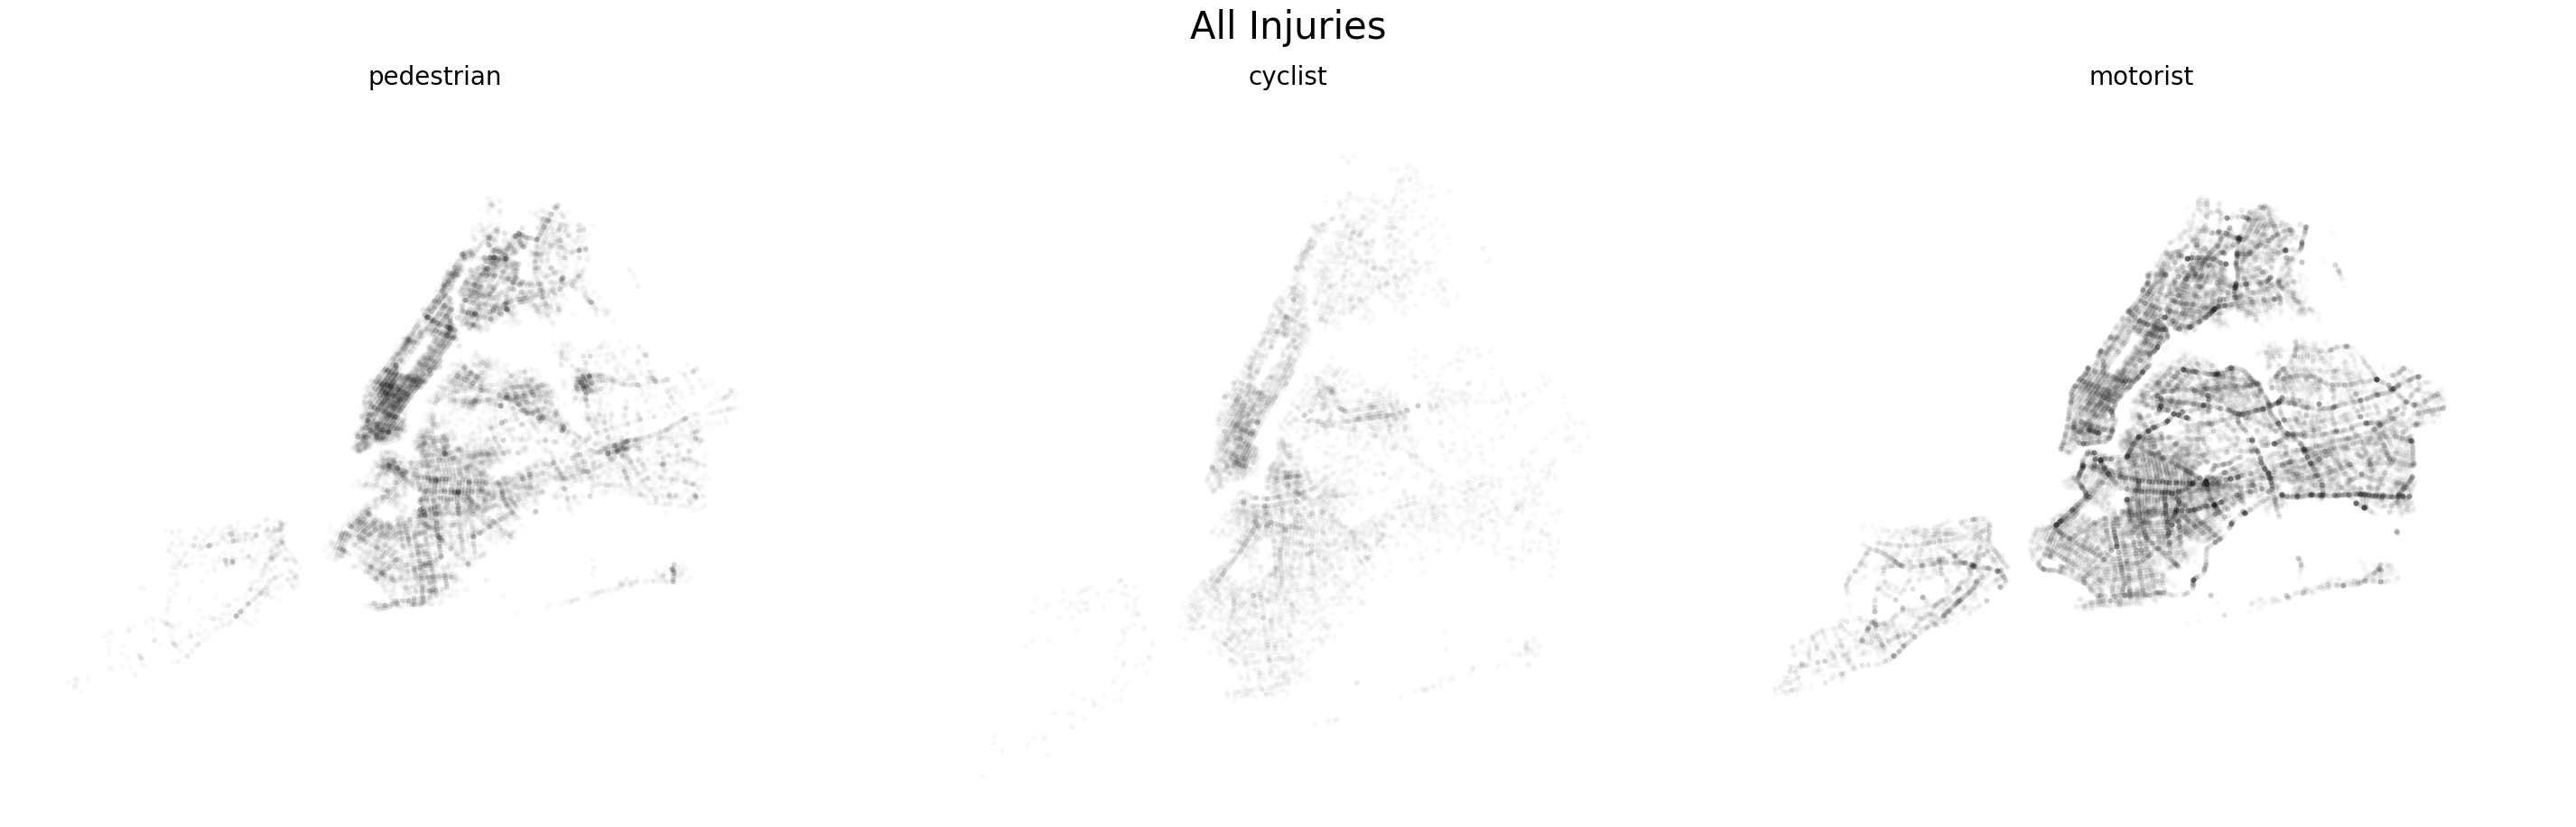

In [17]:
fig = plt.figure(figsize=(30,10))
plt.suptitle('All Injuries', fontsize=30)
dfs = [ped,cyc,mot]
titles = ['pedestrian', 'cyclist', 'motorist']
alphas = [0.025, 0.025, 0.025]
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    df = dfs[i]
    pts = np.array(df.loc[:,['long','lat']].astype(float))
    ax.scatter(pts[:,0],pts[:,1], lw=0, color='k',alpha=alphas[i])
    ax.set_title(titles[i], fontsize=20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
plt.tight_layout(w_pad=0.2, h_pad=0.2, pad=6)

In [18]:
passenger = nyc_coll[nyc_coll.vehicle == 'PASSENGER VEHICLE']

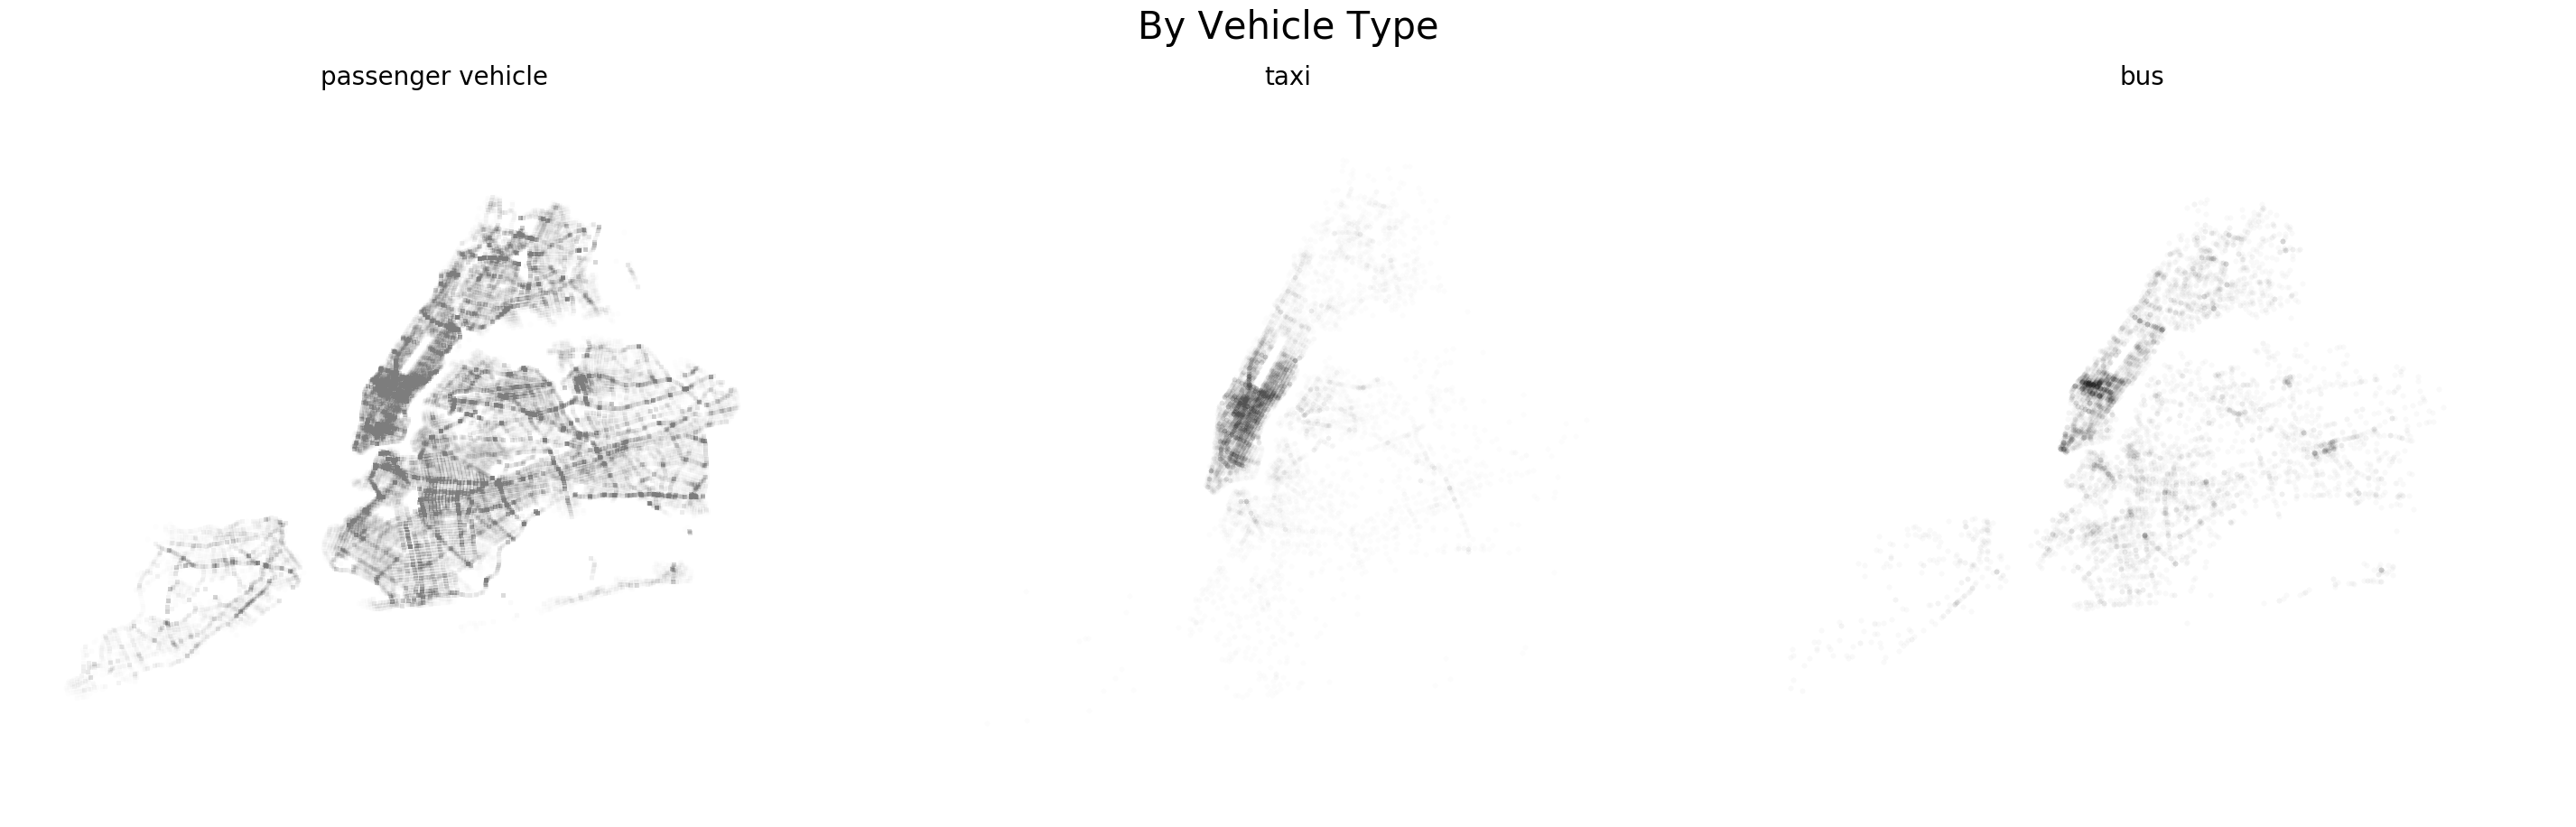

In [19]:
fig = plt.figure(figsize=(30,10))
plt.suptitle('By Vehicle Type', fontsize=30)
dfs = [passenger,taxi,bus]
titles = ['passenger vehicle', 'taxi', 'bus']
alphas = [0.008, 0.01, 0.025]
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    df = dfs[i]
    pts = np.array(df.loc[:,['long','lat']].astype(float))
    ax.scatter(pts[:,0],pts[:,1], lw=0, color='k',alpha=alphas[i])
    ax.set_title(titles[i], fontsize=20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
plt.tight_layout(w_pad=0.2, h_pad=0.2, pad=6)

# Heatmap

In [20]:
min_y = 40.495992
max_y = 40.915568
rangelat = (max_y-min_y)/50
rangelat

0.008391519999999986

In [21]:
min_x = -74.257159
max_x = -73.699215
rangelong = (max_x-min_x)/50
rangelong

0.011158880000000124

In [22]:
def showheatmap(dftest, numgrid, title):
    dftest = dftest
    pts = np.array(dftest.loc[:,['long','lat']].astype(float))
    x = pts[:,0]
    y = pts[:,1]

    gridx = np.linspace(min_x, max_x, numgrid)
    gridy = np.linspace(min_y, max_y, numgrid)

    grid, _, _ = np.histogram2d(y, x, bins=[gridy, gridx])
    
    digy = np.digitize(y, gridy,right=True)
    digx = np.digitize(x, gridx,right=True)

    plt.figure(figsize=(9,6))
    plt.pcolormesh(gridy, gridx, grid, cmap='coolwarm')
    plt.xlim(min_y,max_y)
    plt.ylim(min_x,max_x)
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.colorbar()
    plt.show()
    return grid, digy, digx

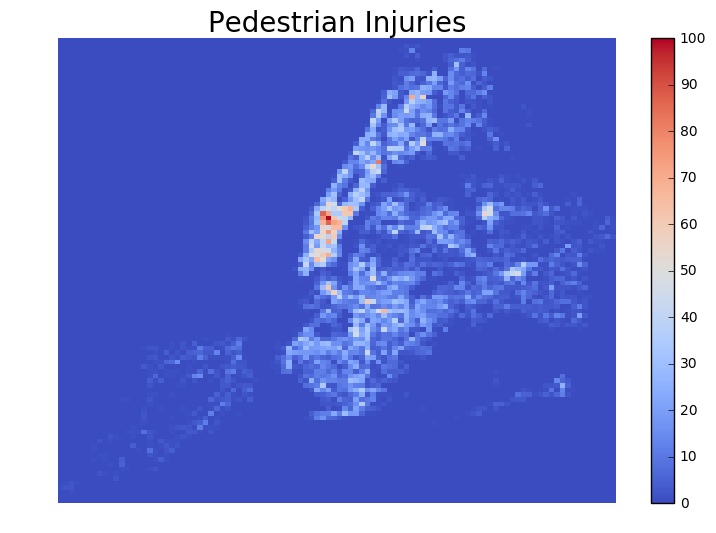

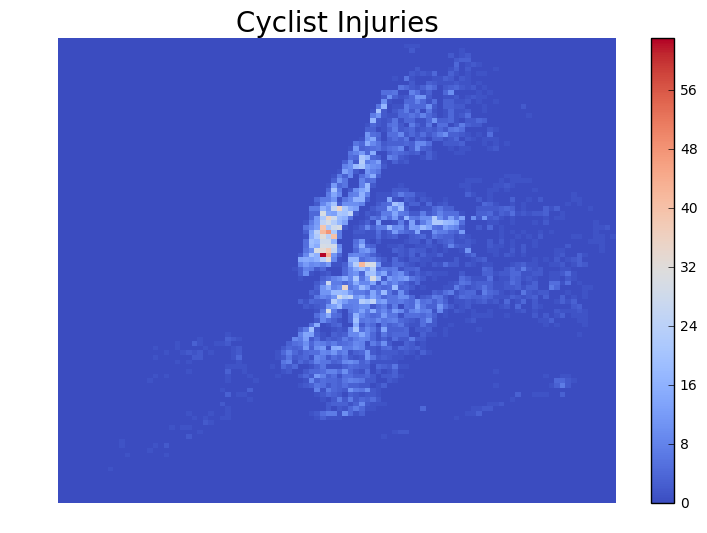

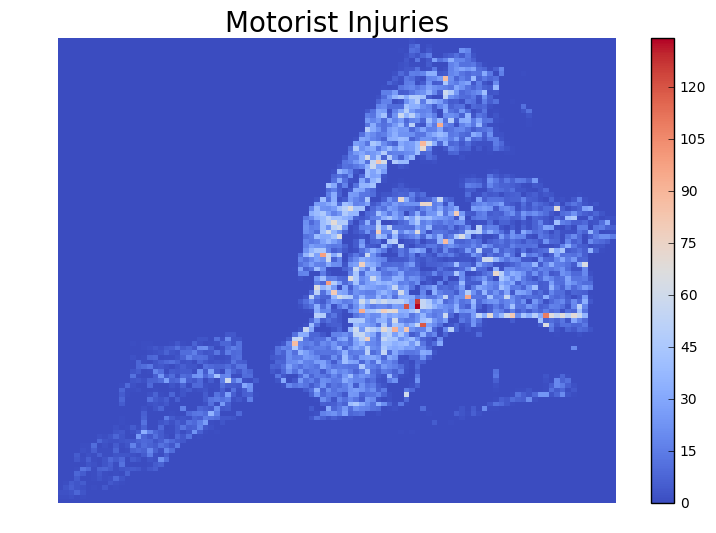

In [23]:
n_grid = 101
ped_grid_100 = showheatmap(ped,n_grid,'Pedestrian Injuries')
cyc_grid_100 = showheatmap(cyc,n_grid,'Cyclist Injuries')
mot_grid_100 = showheatmap(mot,n_grid,'Motorist Injuries')

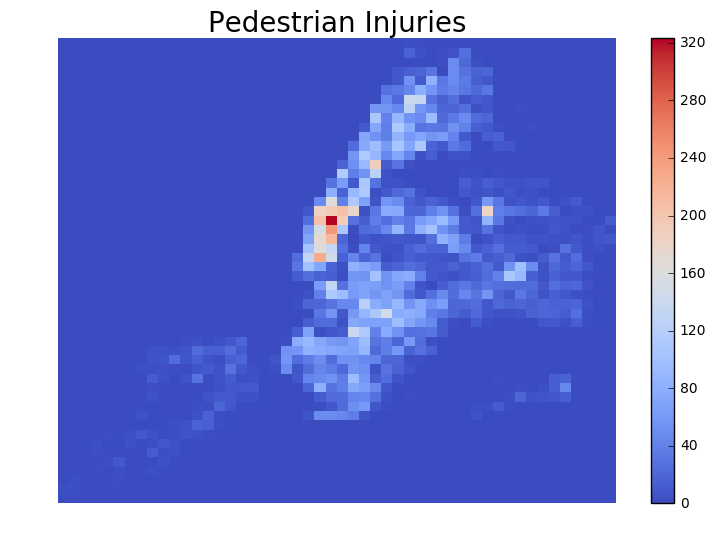

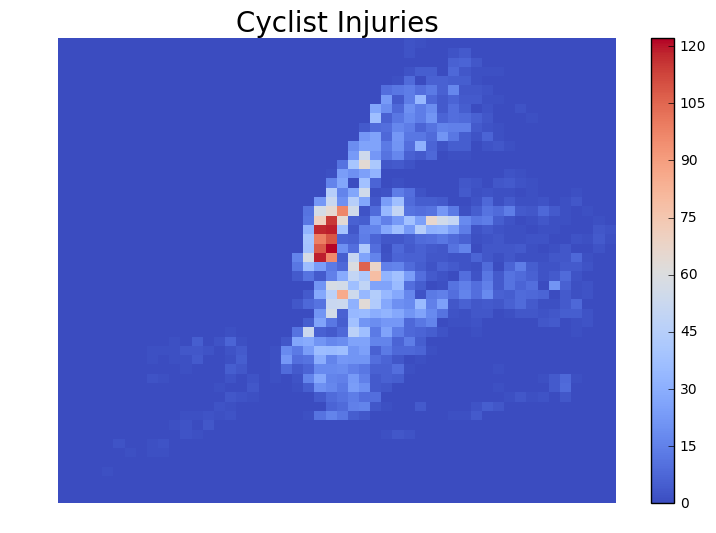

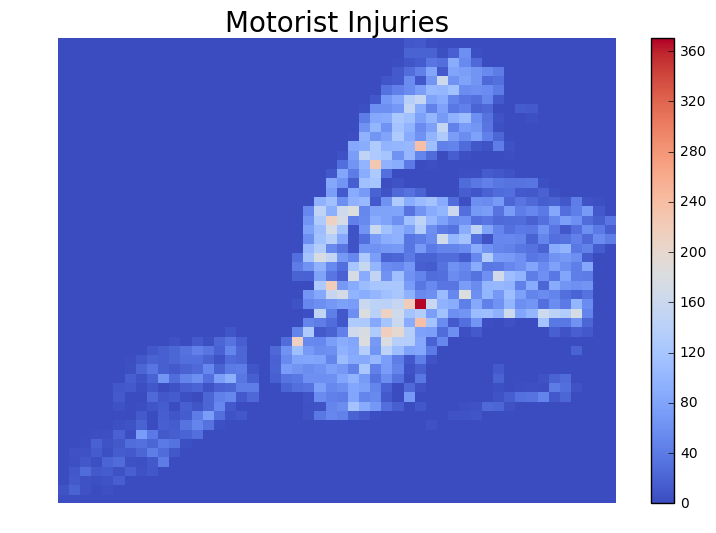

(array([[  2.,   2.,   1., ...,   0.,   0.,   0.],
        [  7.,  20.,   5., ...,   0.,   0.,   0.],
        [  1.,  13.,   5., ...,   0.,   0.,   0.],
        ..., 
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([ 7, 24, 12, ..., 40, 26, 26], dtype=int64),
 array([10, 42, 23, ..., 38, 28, 28], dtype=int64))

In [24]:
n_grid = 51
showheatmap(ped,n_grid,'Pedestrian Injuries')
showheatmap(cyc,n_grid,'Cyclist Injuries')
showheatmap(mot,n_grid,'Motorist Injuries')

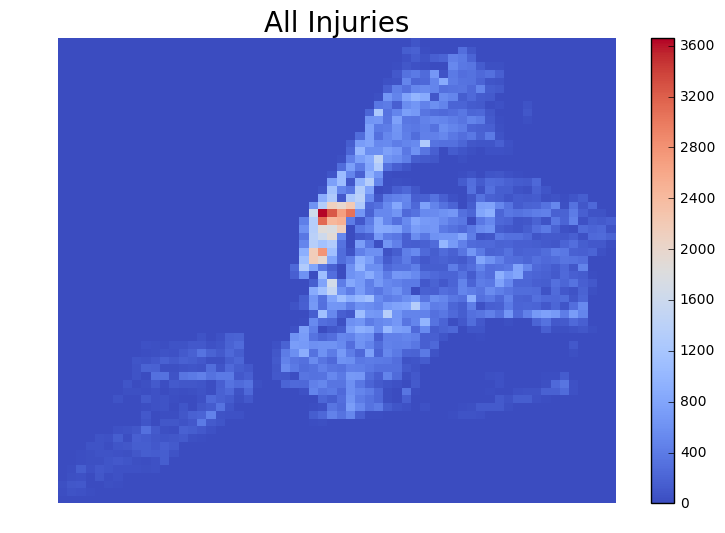

In [25]:
all_injuries = showheatmap(nyc_coll,61,'All Injuries')

In [26]:
#basemap
basemap = all_injuries[0].copy()
basemap[basemap == 0] = -1
basemap[basemap > 0] = 0
basemap

array([[ 0.,  0.,  0., ..., -1., -1., -1.],
       [ 0.,  0.,  0., ..., -1., -1., -1.],
       [ 0.,  0.,  0., ..., -1., -1., -1.],
       ..., 
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [28]:
gridx = np.linspace(min_x, max_x, 61)
gridy = np.linspace(min_y, max_y, 61)

In [29]:
gridy[i],gridy[i+1]

(40.509977866666667, 40.516970800000003)

## Start focusing on pedestrian (from shp)

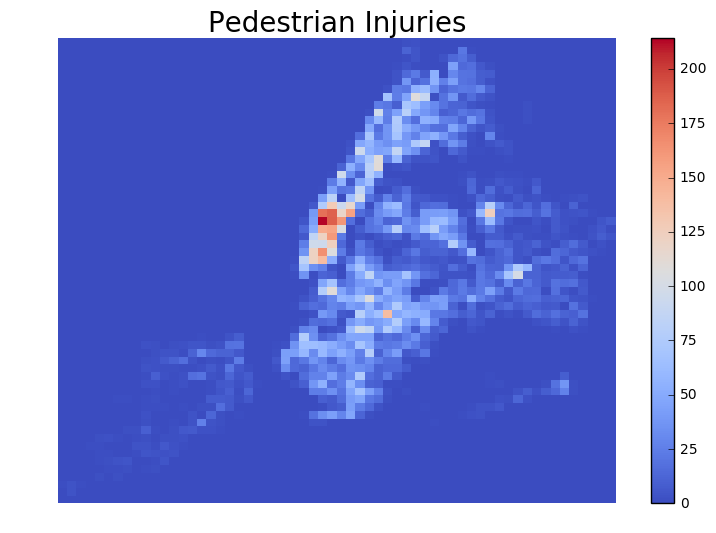

In [30]:
pedgrid = showheatmap(ped,61,'Pedestrian Injuries')

In [31]:
taxi_ped = taxi[taxi.pedestrian_injured>0]

In [32]:
others_ped = ped[ped['vehicle'].isin(['OTHER','VAN','PICK-UP TRUCK'])]
commercial_ped = ped[ped['vehicle'].isin(['LARGE COM VEH(6 OR MORE TIRES)',
                                          'LIVERY VEHICLE',
                                          'SMALL COM VEH(4 TIRES)'])]
non_car_passenger_ped = ped[ped['vehicle'].isin(['BICYCLE'])]
motorcycle_ped = ped[ped['vehicle'].isin(['MOTORCYCLE','SCOOTER'])]
passenger_ped = ped[ped['vehicle'].isin(['PASSENGER VEHICLE',
                                         'SPORT UTILITY / STATION WAGON'])]
ambulance_ped = ped[ped['vehicle'].isin(['AMBULANCE'])]
bus_ped = ped[ped['vehicle'].isin(['BUS'])]
fire_truck_ped = ped[ped['vehicle'].isin(['FIRE TRUCK'])]

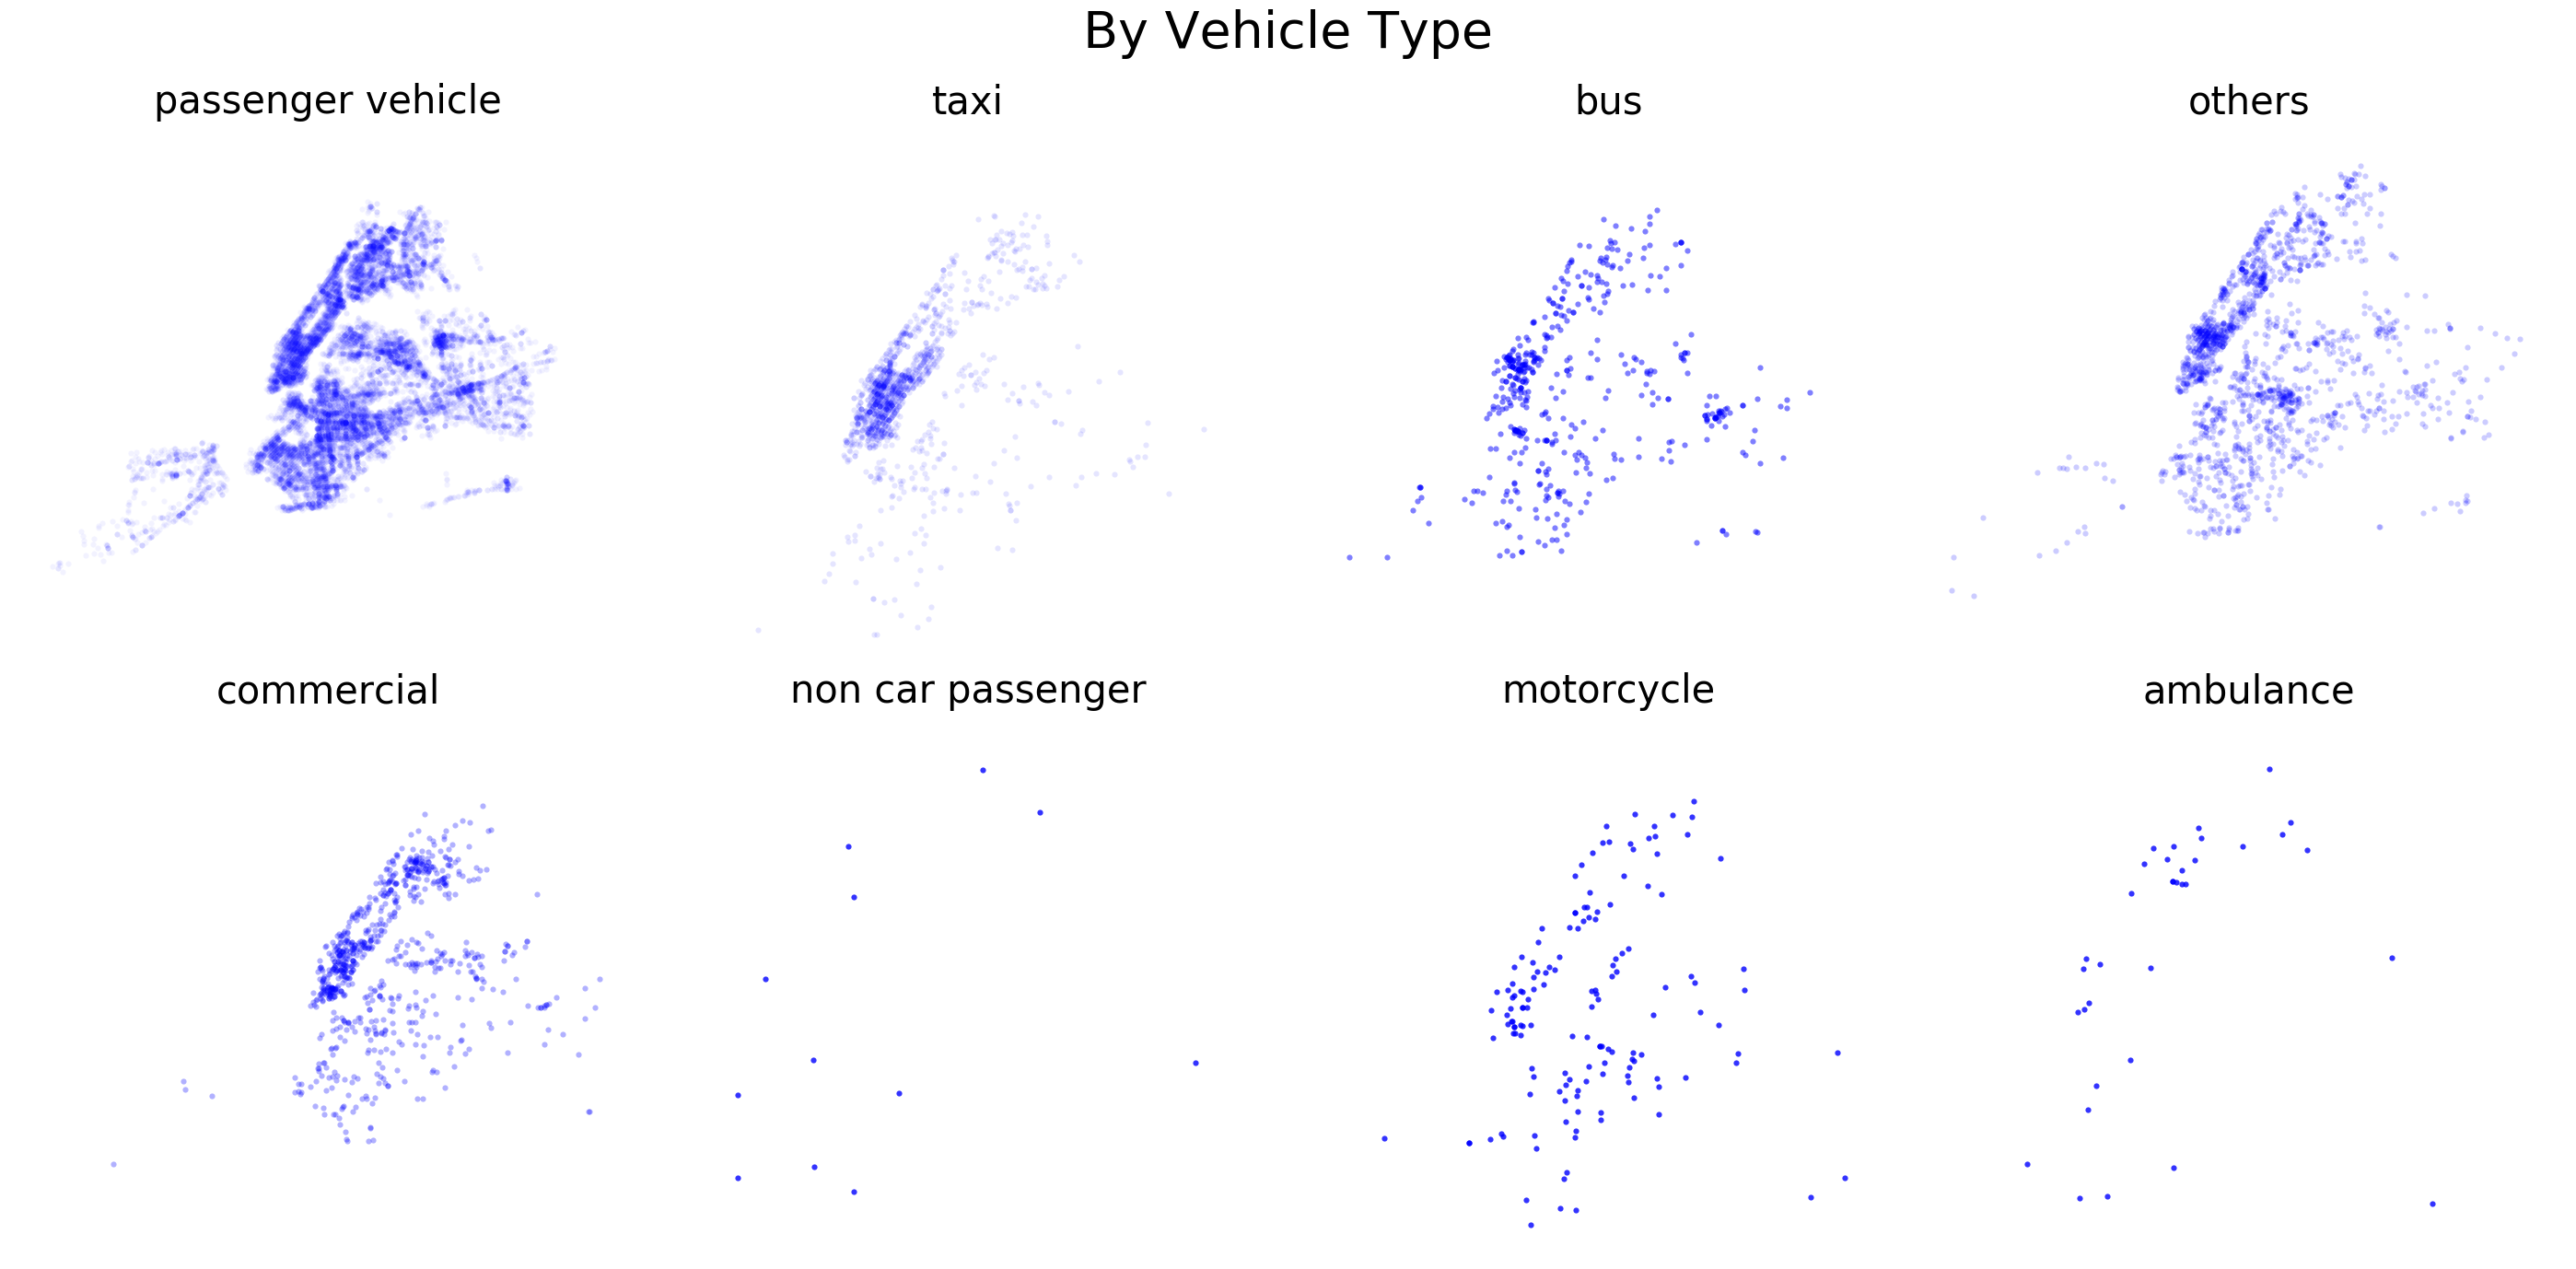

In [33]:
fig = plt.figure(figsize=(30,15))
plt.suptitle('By Vehicle Type', fontsize=40)
dfs = [passenger_ped,taxi_ped,bus_ped,
      others_ped,commercial_ped,non_car_passenger_ped,
      motorcycle_ped,ambulance_ped]
titles = ['passenger vehicle', 'taxi', 'bus',
         'others','commercial','non car passenger',
         'motorcycle','ambulance']
alphas = [0.05, 0.1, 0.5,
         0.2,0.3,0.8,
         0.8,0.8]
for i in range(8):
    ax = fig.add_subplot(2,4,i+1)
    df = dfs[i]
    pts = np.array(df.loc[:,['long','lat']].astype(float))
    ax.scatter(pts[:,0],pts[:,1], lw=0, color='b',alpha=alphas[i])
    ax.set_title(titles[i], fontsize=30)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    ax.axis('equal')
plt.tight_layout(w_pad=0.2, h_pad=0.2, pad=8)

In [34]:
for i in range(len(dfs)):
    filename = titles[i] + '.csv'
    dfs[i].to_csv(filename)

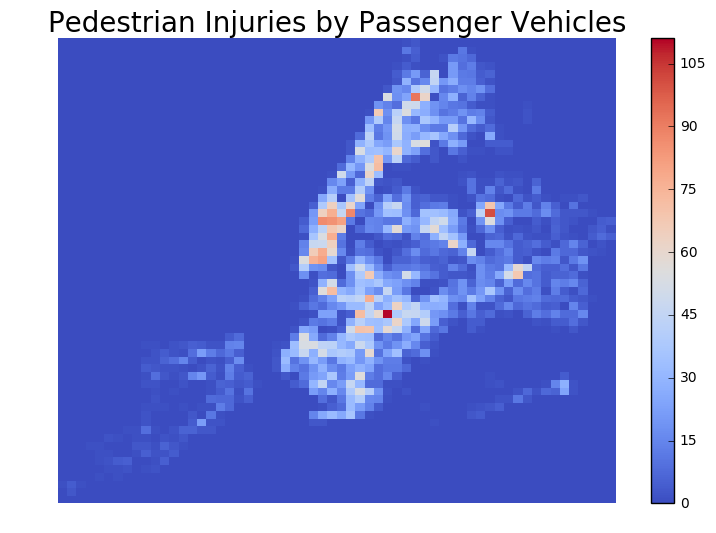

In [35]:
pass_inj = showheatmap(passenger_ped,61,'Pedestrian Injuries by Passenger Vehicles')

In [36]:
np.where(pass_inj>120)

(array([0], dtype=int64),)

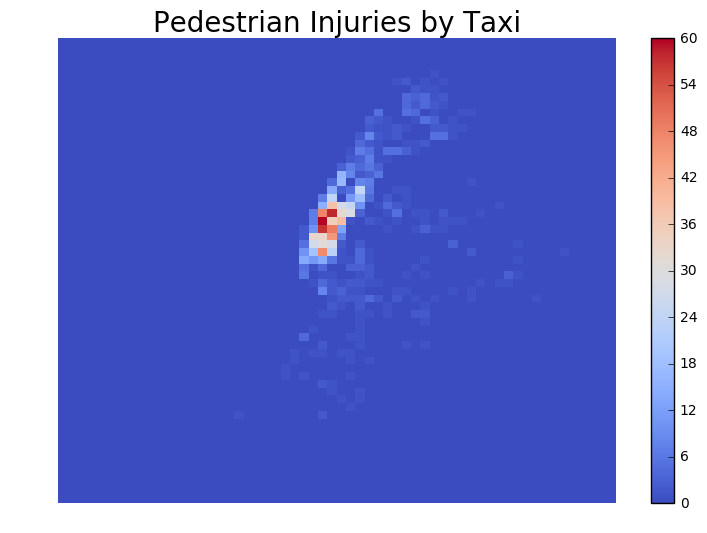

In [37]:
taxi_inj = showheatmap(taxi_ped,61,'Pedestrian Injuries by Taxi')

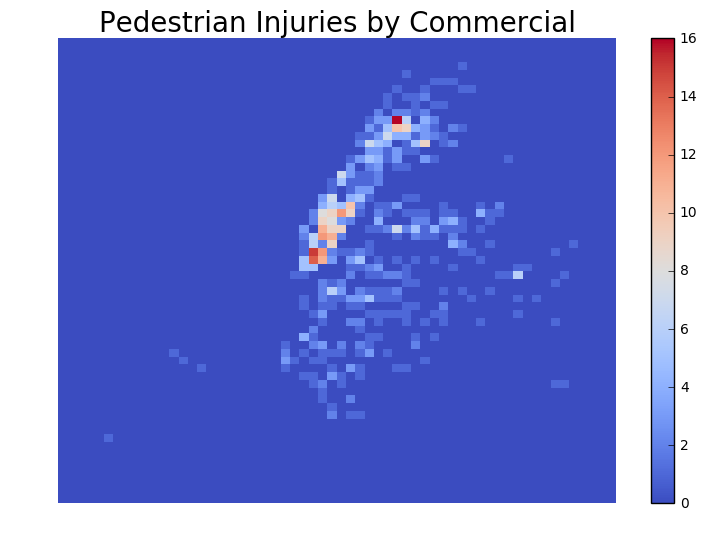

In [38]:
comm_inj = showheatmap(commercial_ped,61,'Pedestrian Injuries by Commercial')

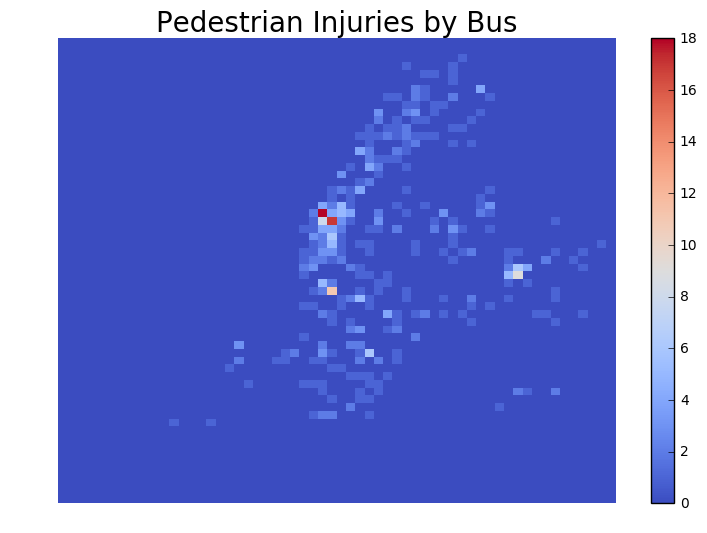

In [39]:
bus_inj = showheatmap(bus_ped,61,'Pedestrian Injuries by Bus')

In [40]:
np.where(bus_inj>8)

(array([0], dtype=int64),)

## Start including passenger

In [41]:
all_passenger = pd.read_csv('station_from_shp.csv')

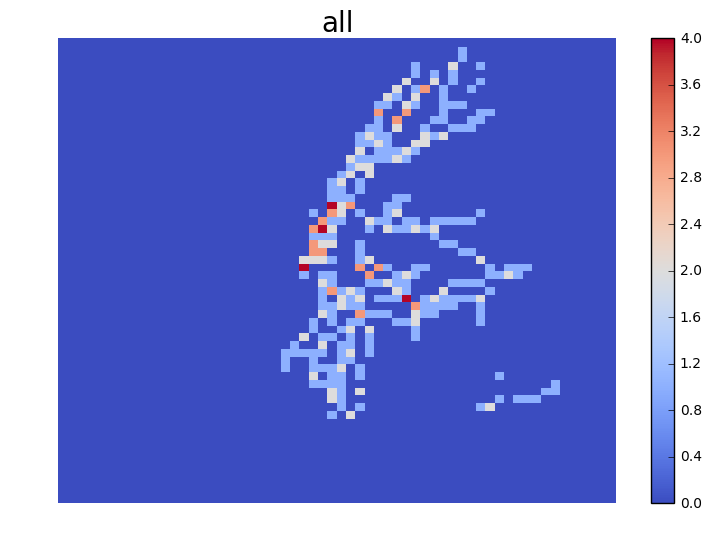

In [42]:
passgrid, digy, digx = showheatmap(all_passenger,61,'all')

In [43]:
all_passenger['digx']=digy
all_passenger['digy']=digx

In [44]:
digy.min(),digy.max(),digx.min(),digx.max()

(12, 59, 25, 54)

In [45]:
passenger_by_grid = all_passenger.groupby(['digx','digy']).sum().reset_index()
passenger_by_grid = passenger_by_grid.rename(columns={'0':'passenger'})

In [46]:
passenger_array = np.zeros((60,60))
for i in passenger_by_grid.index:
    x = passenger_by_grid.ix[i]['digx']
    y = passenger_by_grid.ix[i]['digy']
    passenger_array[x,y] = passenger_by_grid.ix[i]['passenger']

C:\Users\Nurvirta\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


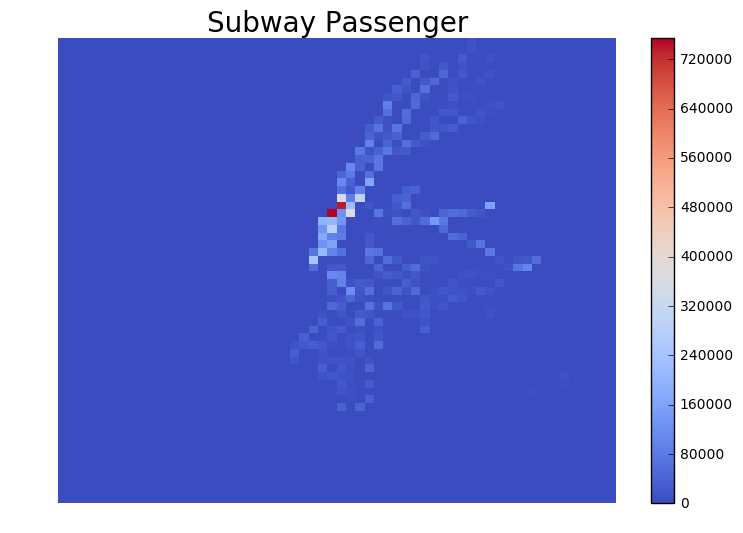

In [47]:
numgrid = 61
gridx = np.linspace(min_x, max_x, numgrid)
gridy = np.linspace(min_y, max_y, numgrid)

plt.figure(figsize=(9,6))
plt.pcolormesh(gridy, gridx, passenger_array, cmap='coolwarm')
plt.xlim(min_y,max_y)
plt.ylim(min_x,max_x)
plt.axis('off')
plt.title('Subway Passenger', fontsize=20)
plt.colorbar()
plt.show()

In [48]:
people = pd.read_csv('ct_table.csv')

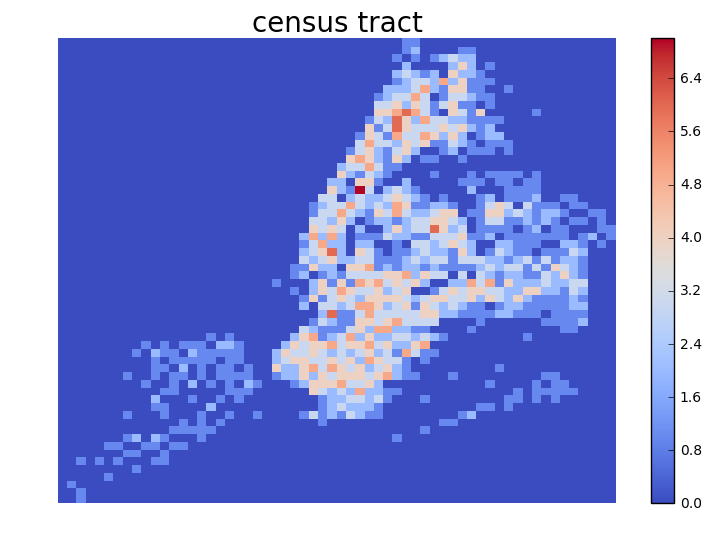

In [49]:
peoplegrid, digy, digx = showheatmap(people,61,'census tract')

In [50]:
digy.min(),digy.max(),digx.min(),digx.max()

(1, 60, 2, 60)

In [51]:
len(digx)

2164

In [52]:
peoplegrid.shape

(60L, 60L)

In [53]:
people['digx']=digy-1
people['digy']=digx-1
people_by_grid = people.groupby(['digx','digy']).sum().reset_index()

In [54]:
people_array = np.zeros((60,60))
for i in people_by_grid.index:
    x = people_by_grid.ix[i]['digx']
    y = people_by_grid.ix[i]['digy']
    people_array[x,y] = people_by_grid.ix[i]['pop']

C:\Users\Nurvirta\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


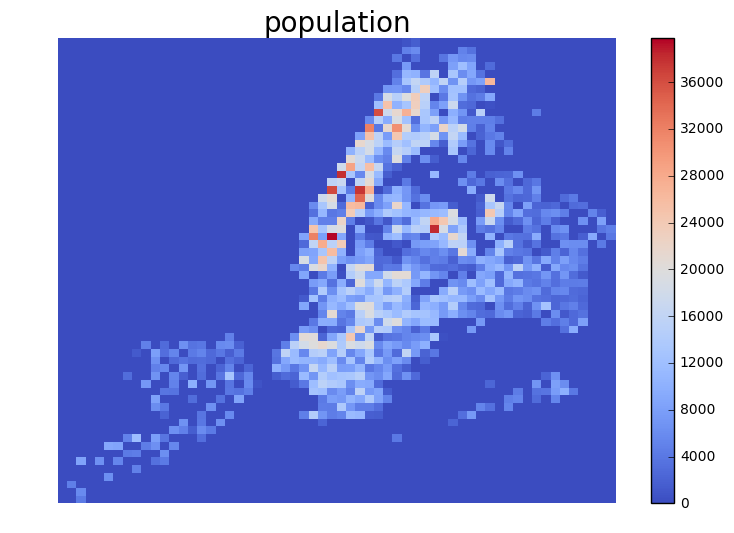

In [55]:
numgrid = 61
gridx = np.linspace(min_x, max_x, numgrid)
gridy = np.linspace(min_y, max_y, numgrid)

plt.figure(figsize=(9,6))
plt.pcolormesh(gridy, gridx, people_array, cmap='coolwarm')
plt.xlim(min_y,max_y)
plt.ylim(min_x,max_x)
plt.axis('off')
plt.title('population', fontsize=20)
plt.colorbar()
plt.show()

In [56]:
pedestrian_array = np.zeros((60,60))
for i in range(60):
    for j in range(60):
        pedestrian_array[i,j] = max(people_array[i,j],passenger_array[i,j])

In [57]:
def showheatmap_bygrid(df, numgrid, title):
    gridx = np.linspace(min_x, max_x, numgrid)
    gridy = np.linspace(min_y, max_y, numgrid)

    plt.figure(figsize=(9,6))
    plt.pcolormesh(gridy, gridx, df, cmap='coolwarm')
    plt.xlim(min_y,max_y)
    plt.ylim(min_x,max_x)
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.colorbar()
    plt.show()

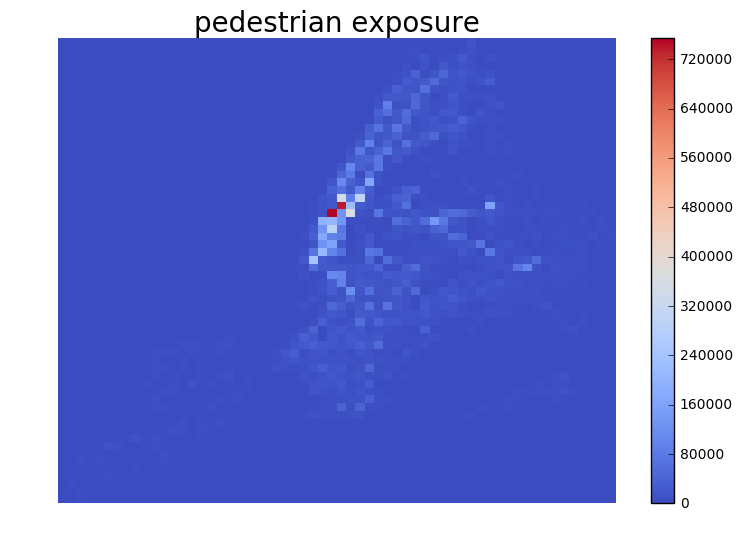

In [58]:
showheatmap_bygrid(pedestrian_array, 61, "pedestrian exposure")

In [59]:
pedestrian_array[36,34] = pedestrian_array[37,34]
pedestrian_array[29,49] = pedestrian_array[30,49]
pedestrian_array[37,36] = 78191
pedestrian_array[(pedestrian_array<400) &
                (pedestrian_array>0)]=0

In [60]:
np.where(pedestrian_array>60000)

(array([25, 25, 27, 27, 28, 29, 29, 29, 30, 30, 31, 32, 32, 32, 32, 32, 32,
        32, 33, 33, 33, 34, 34, 34, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36,
        37, 37, 37, 37, 37, 38, 38, 38, 38, 39, 39, 39, 40, 40, 41, 41, 42,
        42, 43, 43, 44, 45, 45, 46, 46, 48, 48, 50, 51, 53], dtype=int64),
 array([33, 35, 31, 33, 30, 29, 30, 49, 49, 50, 27, 27, 28, 29, 30, 33, 34,
        46, 28, 29, 45, 28, 29, 30, 28, 29, 30, 28, 29, 30, 34, 36, 40, 41,
        29, 30, 31, 34, 36, 30, 31, 37, 46, 30, 31, 32, 30, 32, 30, 33, 31,
        33, 31, 34, 34, 32, 35, 33, 37, 34, 36, 35, 35, 39], dtype=int64))

In [61]:
passenger_array[12,26]

0.0

In [62]:
passenger_array[(passenger_array<2.4*1e8)&\
               (passenger_array>1.8*1e8)]

array([], dtype=float64)

In [63]:
pedestrian_array[37,34]

71363.112330000004

In [65]:
pass_inj[0].shape

(60L, 60L)

In [66]:
def getNormalizedInjuries(injuries_array, passenger_array):
    normalized = np.zeros((60,60))
    for i in range(60):
        for j in range(60):
            if passenger_array[i,j] == 0:
                continue
            else:
                normalized[i,j]=injuries_array[i,j]/passenger_array[i,j]
    return normalized

In [67]:
def showheatmap_bygrid(df, numgrid, title):
    gridx = np.linspace(min_x, max_x, numgrid)
    gridy = np.linspace(min_y, max_y, numgrid)

    plt.figure(figsize=(9,6))
    plt.pcolormesh(gridy, gridx, df, cmap='coolwarm')
    plt.xlim(min_y,max_y)
    plt.ylim(min_x,max_x)
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.colorbar()
    plt.show()

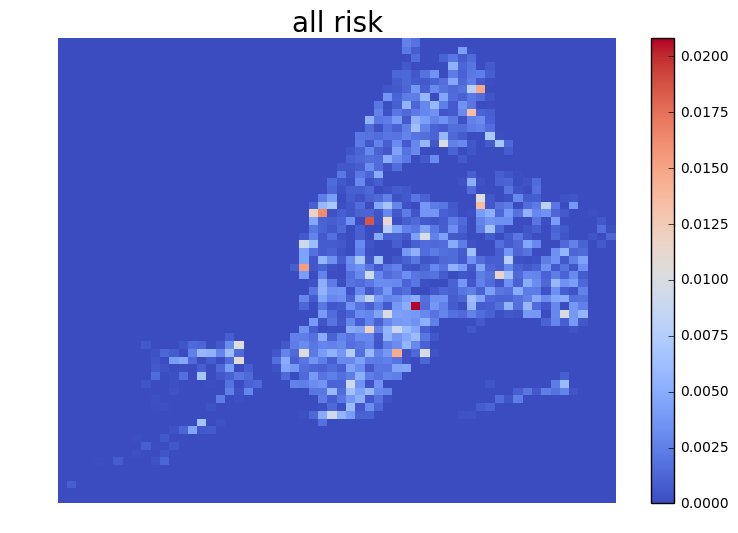

In [68]:
all_inj_normalized = getNormalizedInjuries(pedgrid[0], pedestrian_array)
showheatmap_bygrid(all_inj_normalized, 61, 'all risk')

In [69]:
maxpass = all_inj_normalized.max()
np.where(all_inj_normalized>0.0175)

(array([25, 36], dtype=int64), array([38, 33], dtype=int64))

In [70]:
pedestrian_array[36,33]

1076.0

In [71]:
all_inj_normalized[36,28]

0.0010888108174402411

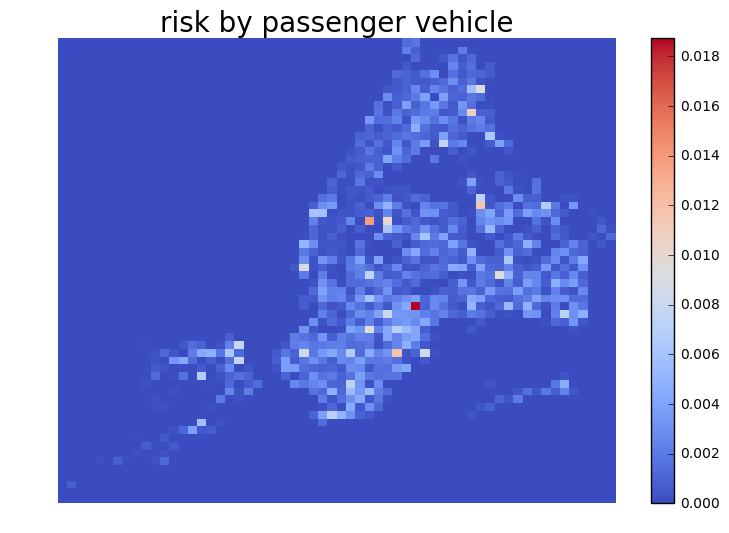

In [72]:
pass_inj_normalized = getNormalizedInjuries(pass_inj[0], pedestrian_array)
showheatmap_bygrid(pass_inj_normalized, 61, 'risk by passenger vehicle')

In [73]:
maxpass = pass_inj_normalized.max()
np.where(pass_inj_normalized==maxpass)

(array([25], dtype=int64), array([38], dtype=int64))

In [74]:
pass_inj_normalized[32,36]

0.0

In [75]:
pass_inj[0][32,36]

3.0

In [76]:
pedestrian_array[32,36]

0.0

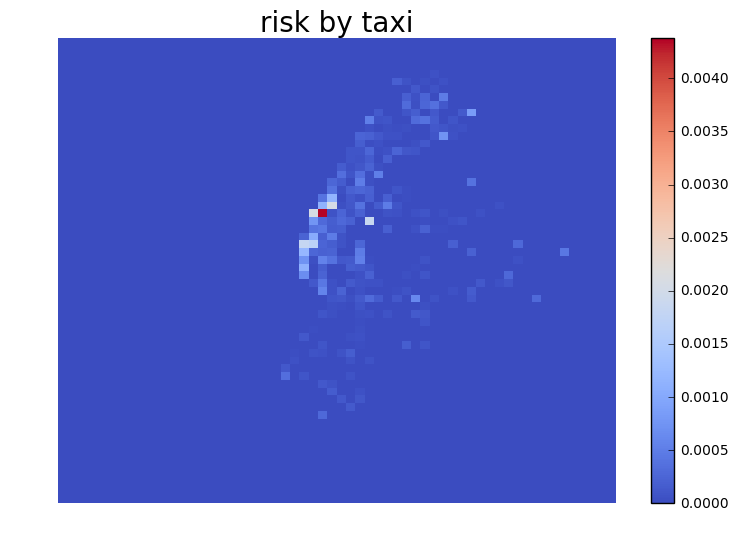

In [77]:
taxi_inj_normalized = getNormalizedInjuries(taxi_inj[0], pedestrian_array)
showheatmap_bygrid(taxi_inj_normalized, 61, 'risk by taxi')

In [78]:
maxtaxi = taxi_inj_normalized.max()
np.where(taxi_inj_normalized==maxtaxi)

(array([37], dtype=int64), array([28], dtype=int64))

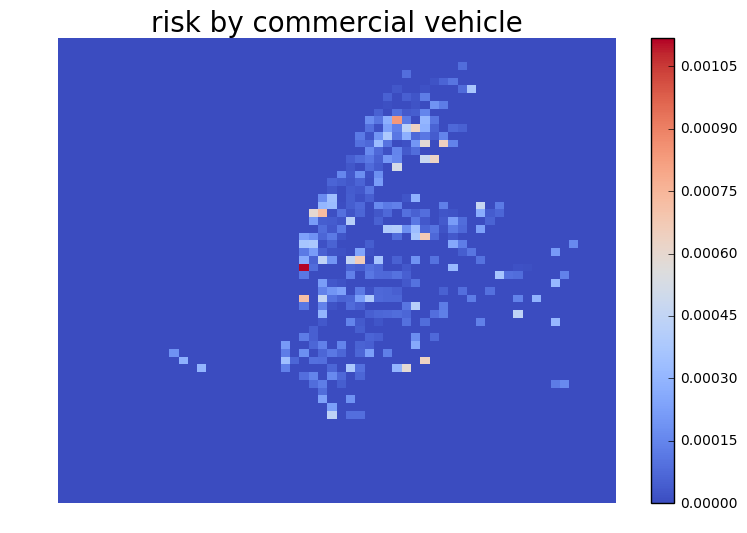

In [79]:
comm_inj_normalized = getNormalizedInjuries(comm_inj[0], pedestrian_array)
showheatmap_bygrid(comm_inj_normalized, 61, 'risk by commercial vehicle')

In [80]:
maxcomm = comm_inj_normalized.max()
np.where(comm_inj_normalized==maxcomm)

(array([30], dtype=int64), array([26], dtype=int64))

In [81]:
pedestrian_array[53,45]

2027.0

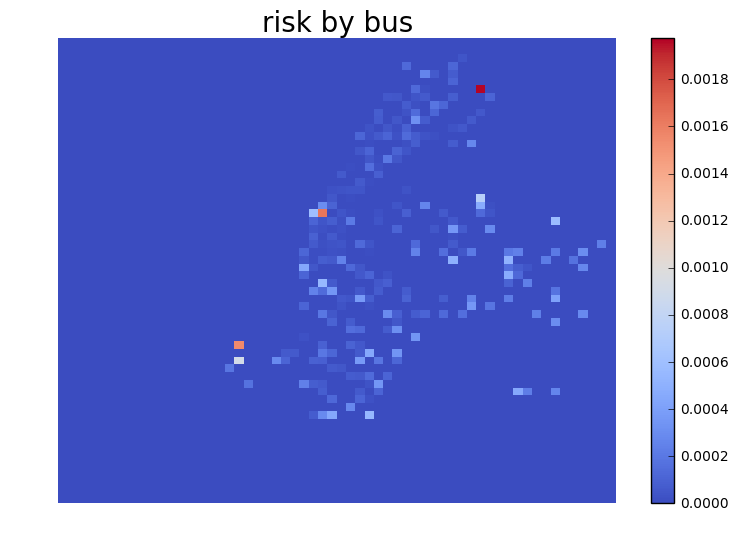

In [82]:
bus_inj_normalized = getNormalizedInjuries(bus_inj[0], pedestrian_array)
showheatmap_bygrid(bus_inj_normalized, 61, 'risk by bus')

In [83]:
bus_inj_normalized.max()

0.0019733596447952641

In [84]:
np.where(bus_inj_normalized >= bus_inj_normalized.max())

(array([53], dtype=int64), array([45], dtype=int64))

In [85]:
pedestrian_array[53,45]

2027.0

In [86]:
def getlatlong(a,b):
    return gridx[b],gridx[b+1], gridy[a],gridy[a+1]

In [87]:
getlatlong(24,23)

(-74.043280466666673,
 -74.033981400000002,
 40.663822400000001,
 40.670815333333337)

In [88]:
getlatlong(31,38)

(-73.903794466666668,
 -73.894495399999997,
 40.712772933333333,
 40.71976586666667)

In [89]:
passenger_array[32,27]

69852.575339999996

In [90]:
taxi_inj[32,27]

TypeError: tuple indices must be integers, not tuple

## normalize both accident and passenger first

In [91]:
pa_new = (pedestrian_array - pedestrian_array.mean())/\
            (pedestrian_array.max()-pedestrian_array.min())
#pa_new = (passenger_array - passenger_array.mean())/\
#            (passenger_array.std())

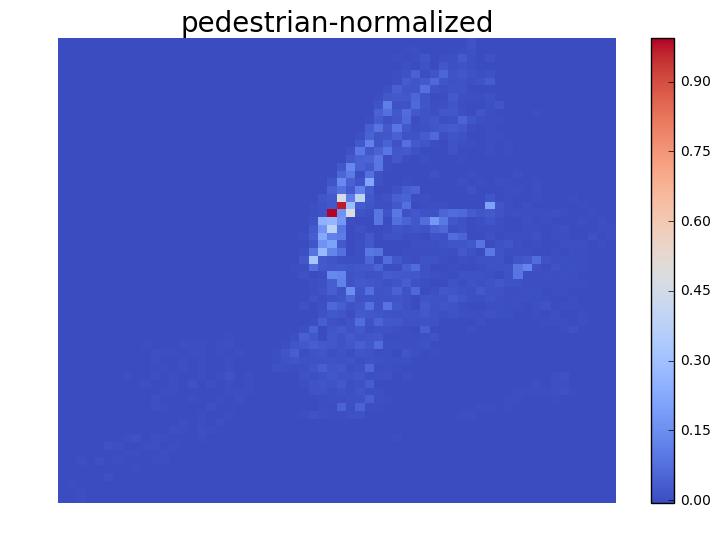

In [92]:
showheatmap_bygrid(pa_new,61,'pedestrian-normalized')

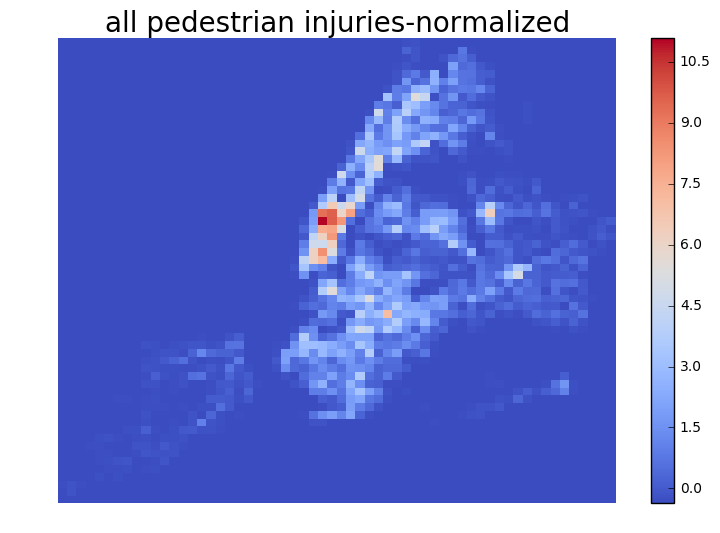

In [93]:
#all_new = (pedgrid[0] - pedgrid[0].mean())/(pedgrid[0].max()-pedgrid[0].min())
all_new = (pedgrid[0] - pedgrid[0].mean())/(pedgrid[0].std())
showheatmap_bygrid(all_new,61,'all pedestrian injuries-normalized')

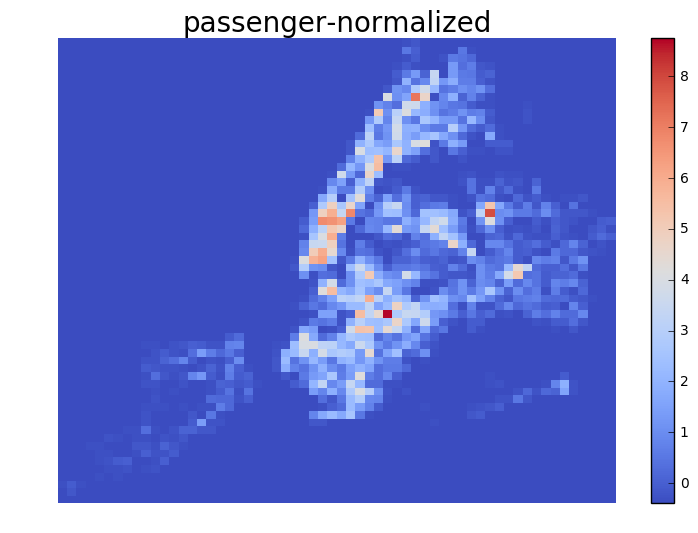

In [94]:
pass_new = (pass_inj[0] - pass_inj[0].mean())/(pass_inj[0].std())
#pass_new = (pass_inj[0] - pass_inj[0].mean())/(pass_inj[0].max()-pass_inj[0].min())
showheatmap_bygrid(pass_new,61,'passenger-normalized')

In [189]:
np.where(pass_new==pass_new.max())

(array([24], dtype=int64), array([35], dtype=int64))

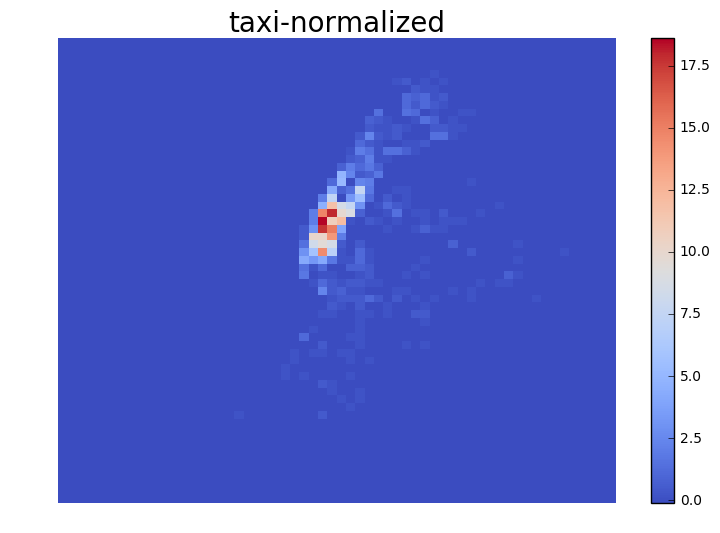

In [95]:
#taxi_new = (taxi_inj[0] - taxi_inj[0].mean())/(taxi_inj[0].max()-taxi_inj[0].min())
taxi_new = (taxi_inj[0] - taxi_inj[0].mean())/(taxi_inj[0].std())
showheatmap_bygrid(taxi_new,61,'taxi-normalized')

In [208]:
np.where(taxi_new>13)

(array([32, 34, 35, 35, 36, 37, 37], dtype=int64),
 array([28, 29, 28, 29, 28, 28, 29], dtype=int64))

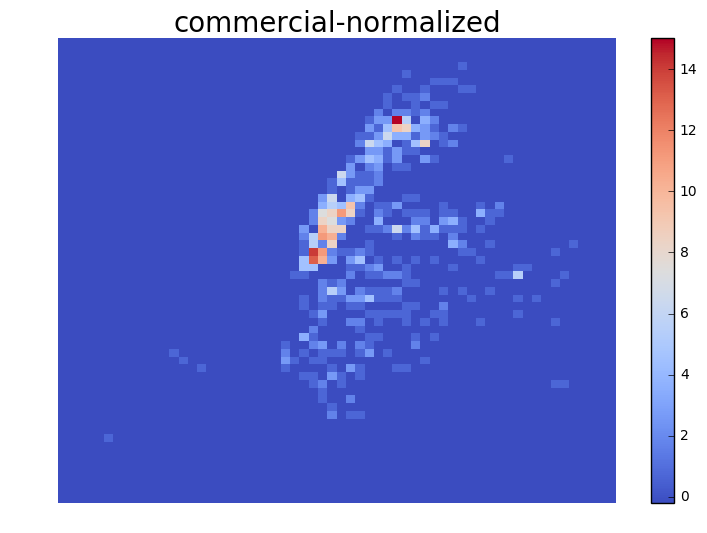

In [96]:
#comm_new = (comm_inj[0] - comm_inj[0].mean())/(comm_inj[0].max()-comm_inj[0].min())
comm_new = (comm_inj[0] - comm_inj[0].mean())/(comm_inj[0].std())
showheatmap_bygrid(comm_new,61,'commercial-normalized')

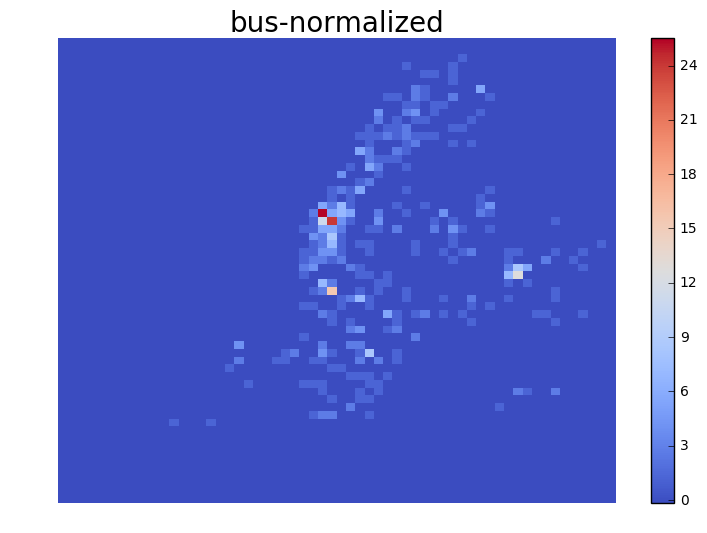

In [97]:
#bus_new = (bus_inj[0] - bus_inj[0].mean())/(bus_inj[0].max()-bus_inj[0].min())
bus_new = (bus_inj[0] - bus_inj[0].mean())/(bus_inj[0].std())
showheatmap_bygrid(bus_new,61,'bus-normalized')

### getnormalized injuries

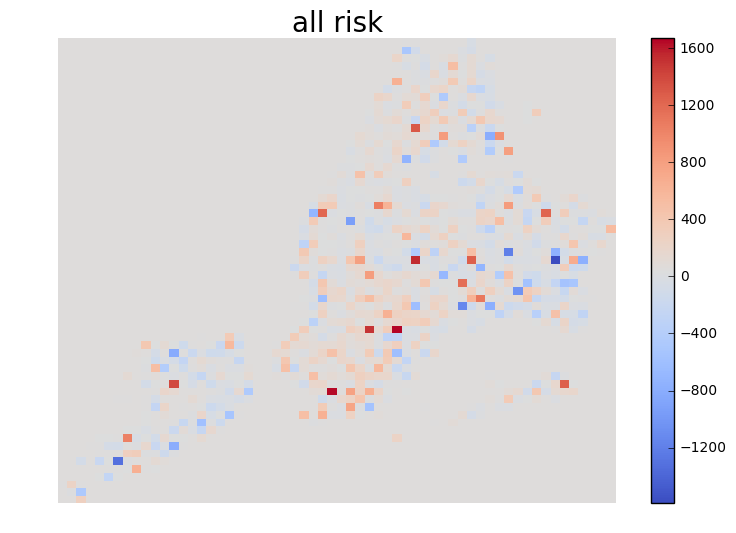

In [98]:
all_inj_normalized2 = getNormalizedInjuries(all_new, pa_new)
avg = all_inj_normalized2.mean()
std = all_inj_normalized2.std()
all_inj_normalized2[(all_inj_normalized2>avg+2*std)|(all_inj_normalized2<avg-2*std)]=0
#all_inj_normalized2[(all_inj_normalized2>50)|(all_inj_normalized2<-40)]=0
showheatmap_bygrid(all_inj_normalized2, 61, 'all risk')

In [99]:
loc = np.where(all_inj_normalized2>1520)

In [100]:
for i,j in zip(loc[0],loc[1]):
    print i,j, getlatlong(i,j)

14 29 (-73.987486066666662, -73.978186999999991, 40.593893066666666, 40.600886000000003)
22 36 (-73.922392599999995, -73.913093533333324, 40.649836533333335, 40.656829466666665)
31 38 (-73.903794466666668, -73.894495399999997, 40.712772933333333, 40.71976586666667)


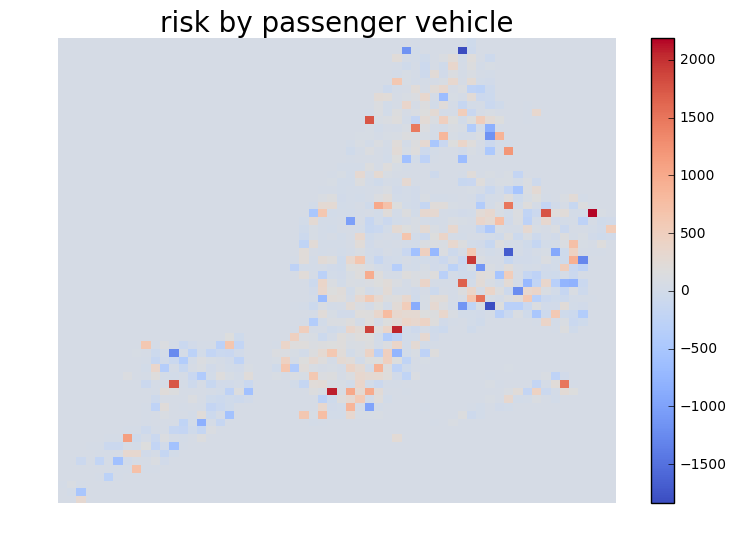

In [101]:
pass_inj_normalized2 = getNormalizedInjuries(pass_new, pa_new)
avg = pass_inj_normalized2.mean()
std = pass_inj_normalized2.std()
pass_inj_normalized2[(pass_inj_normalized2>avg+2*std)|(pass_inj_normalized2<avg-2*std)]=0
showheatmap_bygrid(pass_inj_normalized2, 61, 'risk by passenger vehicle')

In [102]:
loc = np.where(pass_inj_normalized2>2000)
loc

(array([14, 22, 37], dtype=int64), array([29, 36, 57], dtype=int64))

In [103]:
for i,j in zip(loc[0],loc[1]):
    print i,j, getlatlong(i,j)

14 29 (-73.987486066666662, -73.978186999999991, 40.593893066666666, 40.600886000000003)
22 36 (-73.922392599999995, -73.913093533333324, 40.649836533333335, 40.656829466666665)
37 57 (-73.727112199999993, -73.717813133333323, 40.754730533333337, 40.761723466666666)


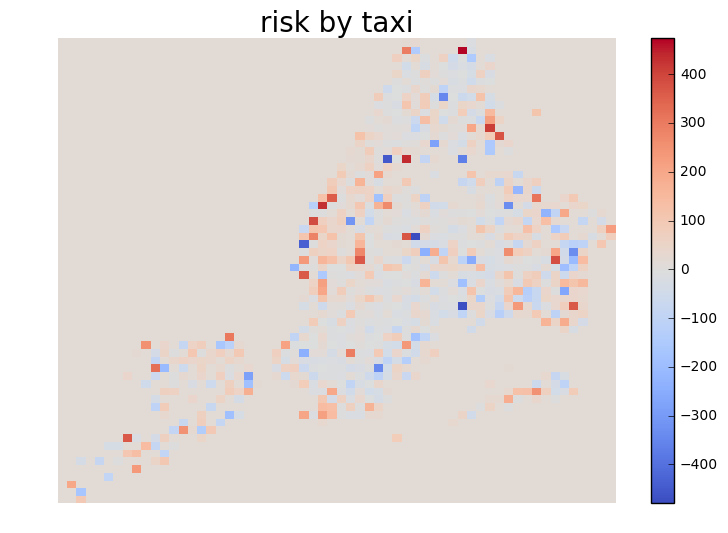

In [104]:
taxi_inj_normalized2 = getNormalizedInjuries(taxi_new, pa_new)
avg = taxi_inj_normalized2.mean()
std = taxi_inj_normalized2.std()
taxi_inj_normalized2[(taxi_inj_normalized2>avg+2*std)|(taxi_inj_normalized2<avg-2*std)]=0
showheatmap_bygrid(taxi_inj_normalized2, 61, 'risk by taxi')

In [105]:
loc = np.where(taxi_inj_normalized2>420)
loc

(array([38, 44, 58], dtype=int64), array([28, 37, 43], dtype=int64))

In [106]:
for i,j in zip(loc[0],loc[1]):
    print i,j, getlatlong(i,j)

38 28 (-73.996785133333333, -73.987486066666662, 40.761723466666666, 40.768716400000002)
44 37 (-73.913093533333324, -73.903794466666668, 40.80368106666667, 40.810673999999999)
58 43 (-73.857299133333328, -73.848000066666657, 40.901582133333335, 40.908575066666664)


In [107]:
np.where(taxi_inj_normalized2>4)

(array([ 0,  0,  0, ..., 59, 59, 59], dtype=int64),
 array([ 0,  1,  2, ..., 57, 58, 59], dtype=int64))

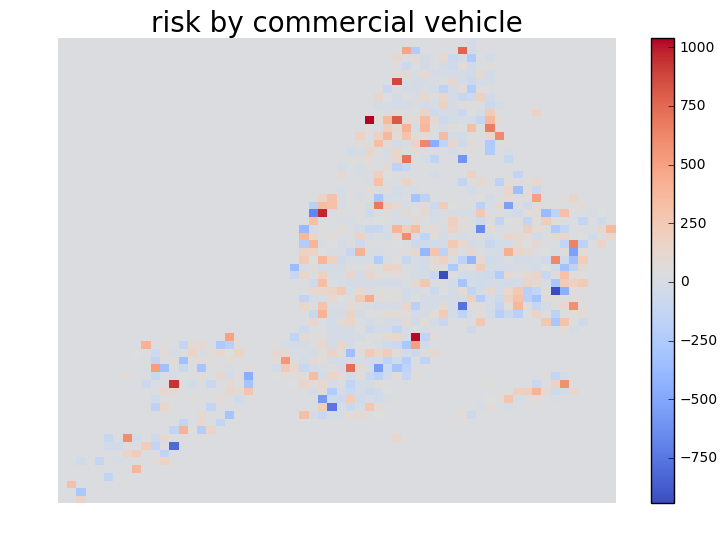

In [108]:
comm_inj_normalized2 = getNormalizedInjuries(comm_new, pa_new)
avg = comm_inj_normalized2.mean()
std = comm_inj_normalized2.std()
comm_inj_normalized2[(comm_inj_normalized2>avg+2*std)|(comm_inj_normalized2<avg-2*std)]=0
showheatmap_bygrid(comm_inj_normalized2, 61, 'risk by commercial vehicle')

In [109]:
loc = np.where(comm_inj_normalized2>950)
loc

(array([21, 37, 49], dtype=int64), array([38, 28, 33], dtype=int64))

In [110]:
for i,j in zip(loc[0],loc[1]):
    print i,j, getlatlong(i,j)

21 38 (-73.903794466666668, -73.894495399999997, 40.642843599999999, 40.649836533333335)
37 28 (-73.996785133333333, -73.987486066666662, 40.754730533333337, 40.761723466666666)
49 33 (-73.950289799999993, -73.940990733333336, 40.838645733333337, 40.845638666666666)


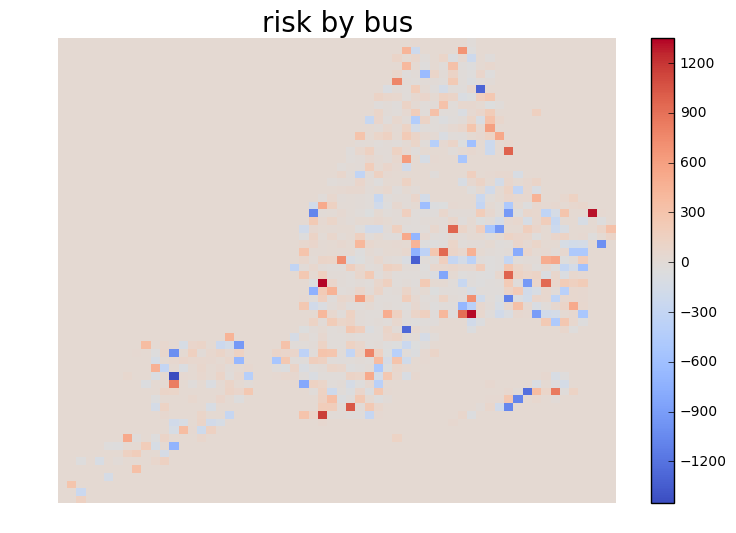

In [111]:
bus_inj_normalized2 = getNormalizedInjuries(bus_new, pa_new)
avg = bus_inj_normalized2.mean()
std = bus_inj_normalized2.std()
bus_inj_normalized2[(bus_inj_normalized2>avg+2*std)|(bus_inj_normalized2<avg-2*std)]=0
showheatmap_bygrid(bus_inj_normalized2, 61, 'risk by bus')

In [112]:
loc = np.where(bus_inj_normalized2>1200)

In [113]:
for i,j in zip(loc[0],loc[1]):
    print i,j, getlatlong(i,j)

24 44 (-73.848000066666657, -73.838701, 40.663822400000001, 40.670815333333337)
28 28 (-73.996785133333333, -73.987486066666662, 40.691794133333332, 40.698787066666668)
37 57 (-73.727112199999993, -73.717813133333323, 40.754730533333337, 40.761723466666666)


In [114]:
pedestrian_array[37,36]

78191.0

In [115]:
pedgrid[0][37,36]

48.0

In [116]:
pa_new[37,36]

0.096795968447647374

In [244]:
def elbow(data, K):
    '''This function is to calculate average within-cluster
    sum of squares, and plot the "elbow"
    data: dataframe of features,
    K: list of selected number of cluster'''
    
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    centroids = [k.cluster_centers_ for k in KM]
    
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    globals()['dist'] = [np.min(D, axis=1) for D in D_k]
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
def plotClusterHeatmap(df,method,cols):
    sortd = df.sort_values(method)
    clustered = sortd[sortd[method]>=0][method]
    fig, ax = plt.subplots(figsize=(20,3)) 
    sns.heatmap(sortd[sortd[method]>=0].loc[:,cols].T,
                cmap='coolwarm',linewidths=0, ax=ax)
    return clustered

def plotcluster(df, selected_cluster):
    basemap_flatten = basemap.flatten()
    clustered_array = basemap_flatten.copy()
    for ix in df[df==selected_cluster].index:
        clustered_array[ix] = df[ix]+1
    clustered_array = clustered_array.reshape(60,60)
    ax = sns.heatmap(clustered_array)
    ax.invert_yaxis()
    return clustered_array
    
def plotallcluster(df):
    basemap_flatten = basemap.flatten()
    clustered_array = basemap_flatten.copy()
    for ix in df.index:
        clustered_array[ix] = df[ix]+1
    ax = sns.heatmap(clustered_array.reshape(60,60), cmap='jet')
    ax.invert_yaxis()

def summarizeCols(df):
    df['others'] = df['OTHER'] + df['PICK-UP TRUCK'] + df['VAN']
    df['commercial'] = df['LARGE COM VEH(6 OR MORE TIRES)'] + df['LIVERY VEHICLE']\
                            + df['SMALL COM VEH(4 TIRES)']
    df['non-car-passenger'] = df['BICYCLE']
    df['motorcycle'] = df['MOTORCYCLE'] + df['SCOOTER']
    df['passenger'] = df['PASSENGER VEHICLE'] + df['SPORT UTILITY / STATION WAGON']
    df['ambulance'] = df['AMBULANCE']
    df['bus'] = df['BUS']
    df['taxi'] = df['TAXI']
    df['fire-truck'] = df['FIRE TRUCK']
    df = df.drop([u'AMBULANCE', u'BICYCLE', u'BUS', u'FIRE TRUCK',
       u'LARGE COM VEH(6 OR MORE TIRES)', u'LIVERY VEHICLE', u'MOTORCYCLE',
       u'OTHER', u'PASSENGER VEHICLE', u'PICK-UP TRUCK',
       u'SCOOTER', u'SMALL COM VEH(4 TIRES)', u'SPORT UTILITY / STATION WAGON',
       u'TAXI', u'UNKNOWN', u'VAN'], axis=1)
    try:
        df = df.drop([u'PEDICAB'], axis=1)
    except:
        df = df
    return df

def getmaketype(df, cols,dftonormalize=None):
    mtype_injuries = pd.DataFrame()
    maketype = sort(df[(df['year']>=2012) | (df['year']<=2014)]['vehicle'].unique())
    for i in maketype:
        dftest = df[df['vehicle']==i]
        pts = np.array(dftest.loc[:,['long','lat']].astype(float))
        x = pts[:,0]
        y = pts[:,1]

        gridx = np.linspace(min_x, max_x, 61)
        gridy = np.linspace(min_y, max_y, 61)

        grid, _, _ = np.histogram2d(y, x, bins=[gridy, gridx])
        if dftonormalize != None:
            grid_ = getNormalizedInjuries(grid, dftonormalize)
        else:
            grid_ = grid
        col_data=grid_.flatten()
        mtype_injuries[i] = col_data
    #selected = mtype_injuries.copy()
    selected = mtype_injuries[mtype_injuries.sum(axis=1)>0].copy()
    selected = summarizeCols(selected)
    selected = selected.loc[:,cols]
    #selected = (selected - selected.mean()) / (selected.max()-selected.min())
    selected = (selected - selected.mean()) / (selected.std())
    selected = selected.apply(lambda x: (x-x.mean())/x.std(), axis=1)
    #selected = selected.apply(lambda x: (x-x.mean())/(x.max()-x.min()), axis=1)
    return selected

In [300]:
cols= ['commercial','passenger','bus','taxi']
ped_mtype = getmaketype(nyc_coll,cols,pedestrian_array)

C:\Users\Nurvirta\Anaconda2\lib\site-packages\ipykernel\__main__.py:84: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [288]:
ped_mtype.head()

commercial  passenger       bus      taxi    others
2      0.398180  -1.572860  0.347555  1.086133 -0.259008
62     0.730306  -1.381924  0.112627  1.105856 -0.566865
121   -0.006298  -1.080732 -0.873815  1.250579  0.710266
185    0.372034  -1.551346  0.316073  1.132485 -0.269246
248    0.523063  -1.482328  0.068327  1.196320 -0.305382

In [302]:
X = ped_mtype.loc[:,cols]
len(X)

954

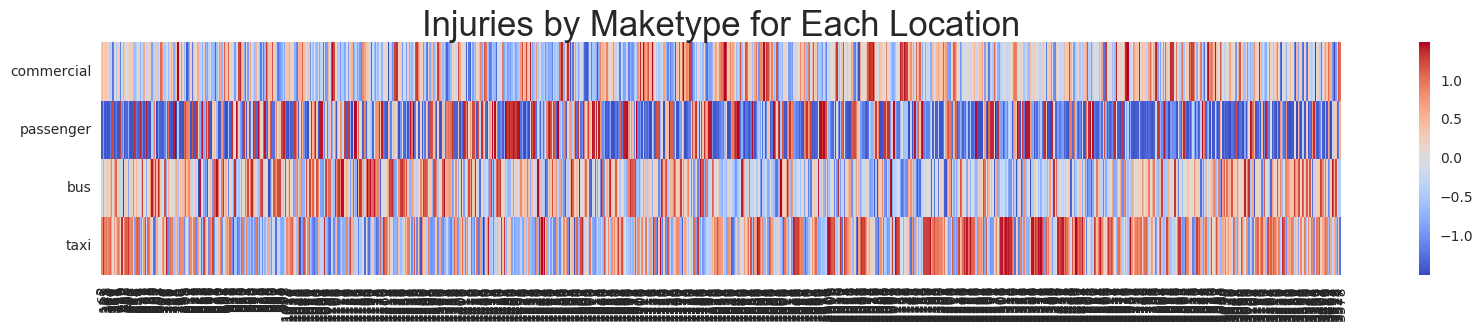

In [303]:
fig, ax = plt.subplots(figsize=(20,3)) 
sns.heatmap(X.T,cmap='coolwarm',linewidths=0, ax=ax)
ax.set_title('Injuries by Maketype for Each Location', fontsize=25)

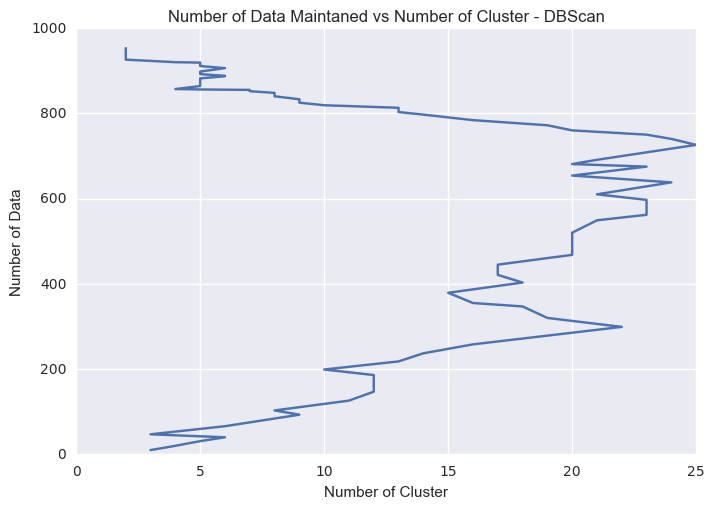

In [304]:
nclust = []
ndat = []
rg = np.arange(0.01,0.6,0.005)
for i in rg:
    db = DBSCAN(i).fit(X)
    nclust.append(len(np.unique(db.labels_)))
    ndat.append(len(db.labels_[db.labels_>=0]))
dbdat = pd.DataFrame({'rg':rg,'nclust':nclust,'ndat':ndat})  
plt.plot(nclust,ndat)
plt.title('Number of Data Maintaned vs Number of Cluster - DBScan')
plt.xlabel('Number of Cluster')
plt.ylabel('Number of Data')

In [292]:
dbdat[dbdat.nclust==15]

nclust  ndat     rg
83      15   611  0.425
88      15   662  0.450

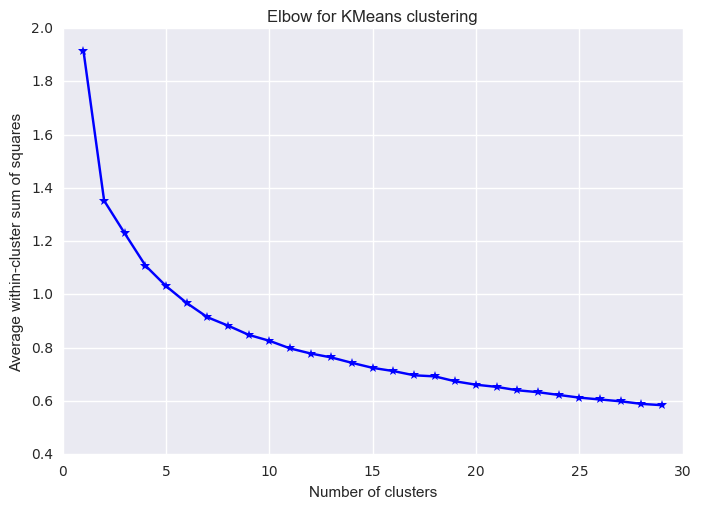

In [293]:
elbow(X,range(1,30))

In [295]:
db = DBSCAN(0.45).fit(X)

In [130]:
km = KMeans(25).fit(X)

In [296]:
ped_mtype['db'] = db.labels_
ped_mtype['km'] = km.labels_

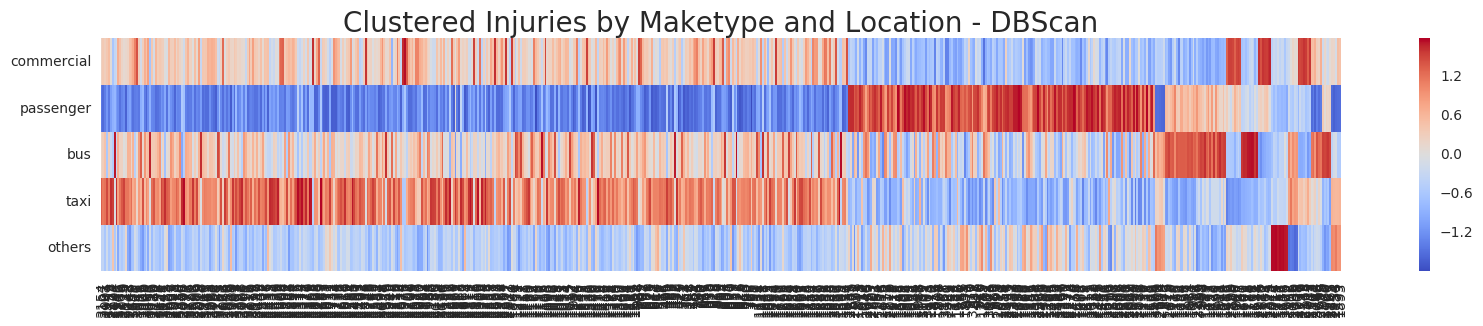

In [297]:
ped_clustered_db = plotClusterHeatmap(ped_mtype,'db',cols)
plt.title('Clustered Injuries by Maketype and Location - DBScan', fontsize=20)

In [227]:
df_to_export = pd.concat([ped_mtype, loc_dict], axis=1).dropna().sort_values(by='db')
df_to_export.to_csv('col-std-row-std-dbscan24.csv')

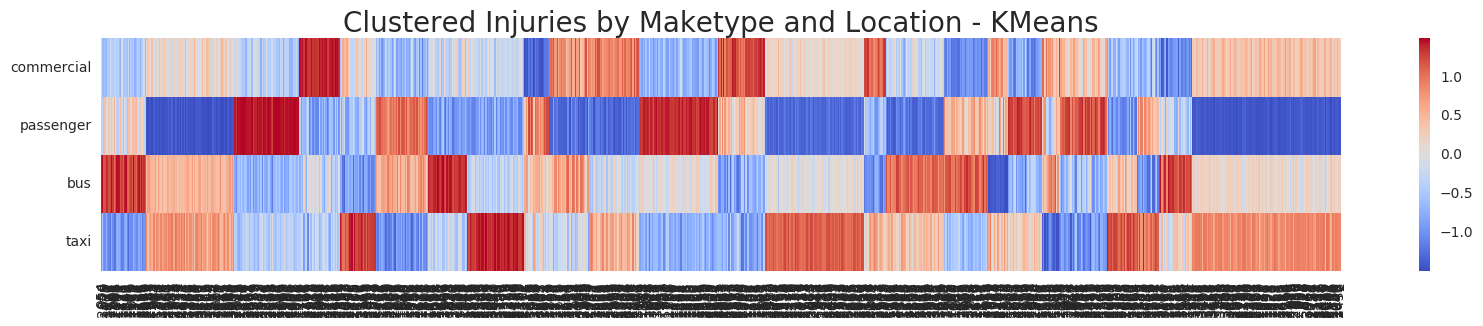

In [397]:
ped_clustered_km = plotClusterHeatmap(ped_mtype,'km',cols)
plt.title('Clustered Injuries by Maketype and Location - KMeans', fontsize=20)

In [ ]:
ped_mtype[ped_mtype.km==3]

In [139]:
y_ax = []
x_ax = []
x1 = []
x2 = []
y1 = []
y2 = []
for ix in range(60*60):
    loc = np.unravel_index([ix],(60,60))
    a = loc[0][0]
    b = loc[1][0]
    ll = getlatlong(a,b)
    y_ax.append(a)
    x_ax.append(b)
    x1.append(ll[0])
    x2.append(ll[1])
    y1.append(ll[2])
    y2.append(ll[3])
loc_dict = pd.DataFrame({'a':y_ax, 'b':x_ax, 'x1':x1, 'x2':x2, 'y1':y1, 'y2':y2})    

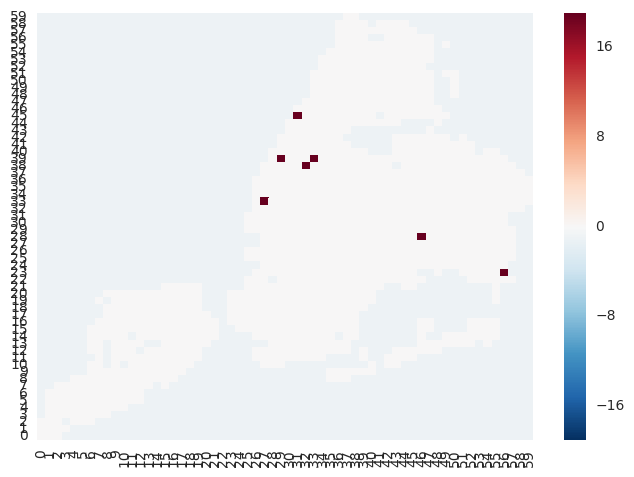

In [277]:
taxi_cluster = plotcluster(ped_clustered_db,18)

In [246]:
clustered_array_dict = {100:'commercial',
                       200:'passenger',
                       300:'bus',
                       400:'taxi'}

In [261]:
array_for_map = np.zeros((60,60))

In [262]:
pass_cluster[pass_cluster<0]=0
array_for_map = array_for_map + pass_cluster
array_for_map[(array_for_map>0)&(array_for_map<100)]=200

In [263]:
bus_cluster[bus_cluster<0]=0
array_for_map = array_for_map + bus_cluster
array_for_map[(array_for_map>0)&(array_for_map<100)]=300

In [264]:
comm_cluster[comm_cluster<0]=0
array_for_map = array_for_map + comm_cluster
array_for_map[(array_for_map>0)&(array_for_map<100)]=100

In [279]:
np.unique(array_for_map)

array([   0.,  100.,  200.,  300.,  400.])

In [278]:
taxi_cluster[taxi_cluster<0]=0
array_for_map = array_for_map + taxi_cluster
array_for_map[(array_for_map>0)&(array_for_map<100)]=400

(0.0, 60.0, 60.0, 0.0)

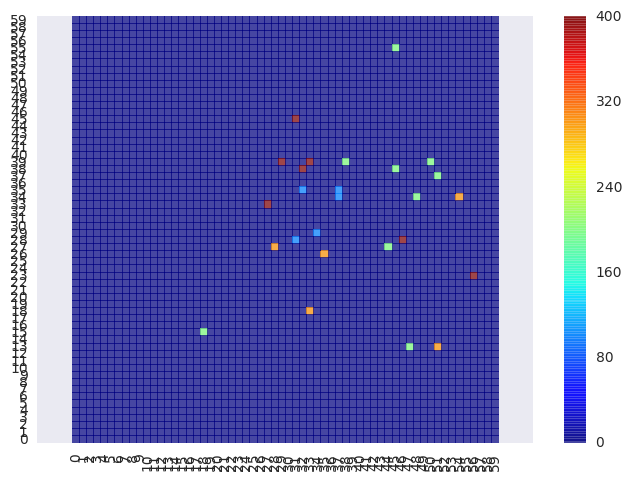

In [283]:
ax = sns.heatmap(array_for_map, alpha=0.7, cmap='jet')
ax.invert_yaxis()
ax.axis('equal')

In [299]:
ped.groupby(['lat','long']).sum().sort_values(by='pedestrian_injured', ascending=False)

Unnamed: 0  hour  dayofweek   year  pedestrian_injured  \
lat       long                                                                 
40.668798 -73.931120    11544632   430         94  68445                  35   
40.813390 -73.956259     9750398   460         75  64424                  32   
40.757232 -73.989792     9862838   360         68  60394                  30   
40.758975 -73.919000     3962464   156         23  22143                  25   
40.820189 -73.890675     7035914   276         66  44290                  25   
40.804376 -73.937420     6422191   340         76  46308                  24   
40.862755 -73.901079     6081815   276         53  46307                  23   
40.651733 -73.930381     3689108   136         35  22144                  23   
40.737361 -73.996839     5556144   229         46  38253                  22   
40.752190 -73.993464     7376109   287         63  40260                  22   
40.861701 -73.891381     6202708   300         59  42278                  22   
40.731351 -73.982555     8032946   278         67  44283                  22   
40.733292 -73.987180     5874342   207         69  40266                  22   
40.678455 -73.949677     6759206   257         56  42275                  22   
40.862750 -73.904933     5828905   289         58  42279                  22   
40.764651 -73.823484     8023843   318         75  44285                  22   
40.748438 -73.984560     6615246   292         49  42277                  21   
40.753482 -73.980889     6331456   340         58  42279                  21   
40.750991 -73.990623     6304052   273         62  38248                  21   
40.756035 -73.986948     5259073   281         67  40269                  21   
40.749788 -73.987769     5536951   219         47  32209                  20   
40.749824 -73.972202     6406513   238         61  38248                  19   
40.650388 -73.958708     6519193   274         54  38246                  19   
40.853815 -73.907331     4024801   184         33  28185                  19   
40.805057 -73.939034     6311893   277         46  38251                  19   
40.632067 -73.918602     4344669   272         57  36240                  18   
40.631708 -73.946481     5132367   241         54  34227                  17   
40.740272 -73.895851     5179901   213         40  34225                  17   
40.759200 -73.984619     1509780    71         14  10066                  17   
40.719972 -73.992897     5093950   198         46  32211                  17   
...                          ...   ...        ...    ...                 ...   
40.697186 -73.928833      312008    22          5   2013                   1   
40.697220 -73.779900      392164    21          5   2013                   1   
40.697716 -73.967727       93124    13          0   2014                   1   
40.698265 -73.933986      188740    16          3   2014                   1   
40.698246 -73.980544      438126    20          4   2013                   1   
40.698190 -73.961899       64246    11          1   2014                   1   
40.698058 -73.809862       95068    17          3   2014                   1   
40.697918 -73.827527      309979    20          1   2013                   1   
40.697903 -73.946796      422025     9          0   2013                   1   
40.697891 -73.899372      459012    19          6   2013                   1   
40.697829 -73.835641      364058    11          2   2013                   1   
40.697819 -73.927819      199867    18          4   2014                   1   
40.697760 -73.793317      507577    12          6   2012                   1   
40.697748 -73.754668       95485    19          3   2014                   1   
40.697721 -73.924530      226009     8          3   2014                   1   
40.697682 -73.987021      273814    20          1   2013                   1   
40.697231 -73.985095      324484    13          4   2013                   1   
40.697679 -73.916366  